# Application -- Twitter Data

A useful practice in social network analysis is to predict future popularity of a subject or event. Twitter, with its public discussion model, is a good platform to perform such analysis.

The available Twitter data is collected by querying popular hashtags related to the 2015 Super Bowl spanning a period starting from 2 weeks before the game to a week after the game. We will use data from some of the related hashtags to train a regression model and then use the model to make predictions for other hashtags.

To train a model, we need to prepare training sets out of the data, extract featuers for them, and then fit a regression model on it. The regression model will try to fit a curve through observed values of features and outcomes to create a predictor for new samples. Designing and choosing good features is one of the emost important steps in this process and is essential to getting a more accurate system. 

## Part 1. Popularity Prediction

### 1-1. Data Preprocessing and Visualization

In [1]:
import json
import numpy as np
import pandas as pd
from pandas import DataFrame
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime
import pytz
import math
import time

The training data consists of 6 text files, each one containing tweet data from one hashtag as indicated in the filenames.

In [2]:
def get_data(hashtag):   
    dictionary = {'#GoHawks': 'tweets_#gohawks.txt',
                     '#GoPatriots': 'tweets_#gopatriots.txt',
                  '#Patriots': 'tweets_#patriots.txt',
                     '#NFL': 'tweets_#nfl.txt',
                     '#SB49': 'tweets_#sb49.txt',
                     '#SuperBowl': 'tweets_#superbowl.txt'}
    # number_of_tweets_per_hr = []
    number_of_followers = []
    number_of_retweets = []
    day_of_tweet = []
    hour_of_tweet = []
    month_of_tweet = []
    time_stamp = []
    #rank=[]
    pst_tz = pytz.timezone('America/Los_Angeles')
    file = open('./tweet_data/'+ dictionary[hashtag],errors='ignore')
    # need to handle duplicates in users tweeting for actual number of users and for the number of followers
    authors = set()
    for line in file:
        data = json.loads(line)
        # look up the time a tweet is posted
        timestamp = (data['citation_date'])
        time_stamp.append(timestamp)
        # convert UIX time to human-readable date
        timedata = datetime.datetime.fromtimestamp(timestamp,pst_tz)
        #ranktmp=100*timedata.month+timedata.day+0.01*timedata.hour
        #rank.append(ranktmp)
        day_of_tweet.append(timedata.day)
        hour_of_tweet.append(timedata.hour)
        month_of_tweet.append(timedata.month)
        # assess the number of retweets of a tweet:
        number_of_retweets.append(data['metrics']['citations']['total'])
        if data['tweet']['user']['id'] not in authors:
            authors.add(data['tweet']['user']['id'])
        # number of followers of the person tweeting 
        number_of_followers.append(data['author']['followers'])
    file.close()
    number_of_users = len(authors)
    total_hours = float(max(time_stamp) - min(time_stamp))/3600.0
    return month_of_tweet, day_of_tweet, hour_of_tweet, number_of_followers, number_of_retweets, number_of_users

In [3]:
def process_data(month,day,hour,followers,retweets,users):
    monthsum=[month[0]]
    daysum=[day[0]]
    hoursum=[hour[0]]
    followersum=[followers[0]]
    retweetsum=[retweets[0]]
    tweetsum=[1]
    maxfollowers=[followers[0]]
    for i in range(len(day)):
        if i != 0:
            for j in (range(len(daysum))):
                if (month[i] == monthsum[j]) and (day[i] == daysum[j]) and (hour[i] == hoursum[j]):
                    followersum[j]=followersum[j]+followers[i]
                    retweetsum[j]=retweetsum[j]+retweets[i]
                    tweetsum[j]=tweetsum[j]+1
                    if followers[i] > maxfollowers[j]:
                        maxfollowers[j]=followers[i]
                    break
                else:
                    if j == len(daysum)-1:
                        monthsum.append(month[i])
                        daysum.append(day[i])
                        hoursum.append(hour[i])
                        followersum.append(followers[i])
                        retweetsum.append(retweets[i])
                        tweetsum.append(1)
                        maxfollowers.append(followers[i])
    data={'month':monthsum,'day':daysum,'hour':hoursum,'follower':followersum,'retweet':retweetsum,'tweet':tweetsum,'Maxfollowers':maxfollowers}
    df = DataFrame(data)
    df=df.sort_values(by=['month','day','hour'])
    df=df.reset_index(drop=True)
    emptysum=build_empty(j)
    df_new=merge(df,emptysum)
    total_hour=len(df_new.tweet)
    return df_new,users,total_hour

In [4]:
def plot(df, hashtag):
    plt.bar([i for i in range(len(df.tweet))], df.tweet)
    plt.xlabel('Hours')
    plt.ylabel('Number of Tweets')
    plt.title('Hours VS Number of Tweets for '+ str(hashtag))
    plt.show()

In [5]:
def merge(df,dfempty):
    df_new=dfempty
    for i in range(len(dfempty)):
        for j in range(len(df)):
            if df.month[j] == dfempty.month[i] and  df.day[j] == dfempty.day[i] and df.hour[j] == dfempty.hour[i]:
                df_new.follower[i] = df.follower[j]
                df_new.retweet[i] = df.retweet[j]
                df_new.tweet[i] = df.tweet[j]
                df_new.Maxfollowers[i] = df.Maxfollowers[j]  
                break           
    return df_new

In [6]:
# Build a timestamp summary matrix
def build_empty(j):
    d1 = datetime.datetime(2015, 1, 14, 0, 0)
    unixtime1 = time.mktime(d1.timetuple())
    d2 = datetime.datetime(2015, 2, 7, 10, 0)
    unixtime2 = time.mktime(d2.timetuple())
    # 24 days * 24 hours/day + 10 hours = 587
    timestampaxis=np.linspace(unixtime1,unixtime2,num=587)
    monthempty=[]
    dayempty=[]
    hourempty=[]
    pst_tz = pytz.timezone('America/Los_Angeles')
    for i in range(len(timestampaxis)):
        timedata=datetime.datetime.fromtimestamp(timestampaxis[i],pst_tz)
        monthempty.append(timedata.month)
        dayempty.append(timedata.day)
        hourempty.append(timedata.hour)
    data={'month':monthempty,'day':dayempty,'hour':hourempty,'tweet':[0]*len(timestampaxis),'follower':[0]*len(timestampaxis),'retweet':[0]*len(timestampaxis),'Maxfollowers':[0]*len(timestampaxis)}
    emptysum=DataFrame(data)
    return emptysum

### 1 & 2

1: Report the following statistics for each hashtag, i.e. each file:

- Average number of tweets per hour
- Average number of followers of users posting the tweets per tweet (to make it simple, we average over the number of tweets; if a users posted twice, we count the user and the user’s followers twice as well)
- Average number of retweets per tweet


2: Plot "number of tweets in an hour" over time for #Superbowl and #NFL (a bar plot with 1-hour bins). The tweets are stored in separate files for different hashtags and files are names as tweet_[#hashtag].txt.

For the dataset #NFL
Average number of tweets per hour: 396.97103918228277
Average number of followers of users posting the tweets: 15652.217242223855
Average number of retweets: 5.15138810851306 



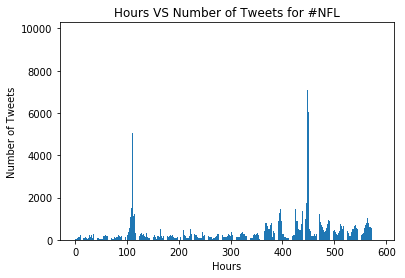

For the dataset #SuperBowl
Average number of tweets per hour: 2067.824531516184
Average number of followers of users posting the tweets: 16707.274326499828
Average number of retweets: 4.532093631865189 



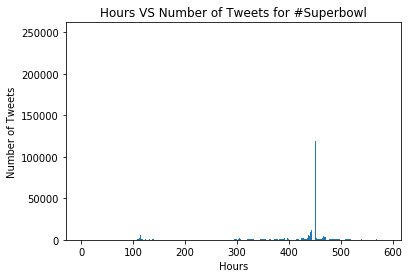

For the dataset #GoHawks
Average number of tweets per hour: 288.11243611584325
Average number of followers of users posting the tweets: 5208.0543437513015
Average number of retweets: 4.727350985101982 



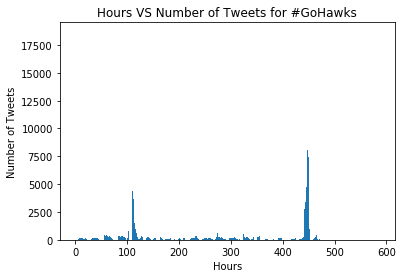

For the dataset #GoPatriots
Average number of tweets per hour: 40.052810902896084
Average number of followers of users posting the tweets: 2035.3087887426457
Average number of retweets: 2.008127615697216 



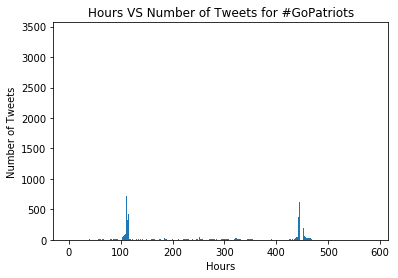

For the dataset #Patriots
Average number of tweets per hour: 750.6320272572402
Average number of followers of users posting the tweets: 4852.411315256763
Average number of retweets: 2.6407693004924786 



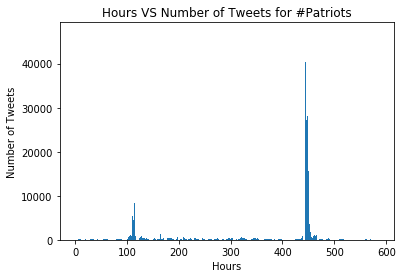

For the dataset #SB49
Average number of tweets per hour: 1266.8637137989779
Average number of followers of users posting the tweets: 14343.25328288697
Average number of retweets: 3.4940012828497857 



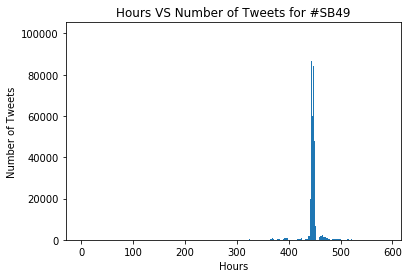

In [7]:
# #NFL data load
M,D,H,F,R,U=get_data('#NFL')
df_NFL,users_NFL,total_hours_NFL=process_data(M,D,H,F,R,U)
print('For the dataset #NFL')
print('Average number of tweets per hour:', sum(df_NFL.tweet)/total_hours_NFL)
print('Average number of followers of users posting the tweets:', (sum(df_NFL.follower)/users_NFL))
print('Average number of retweets:', sum(df_NFL.retweet)/users_NFL, '\n')
plot(df_NFL,'#NFL')
# #Superbowl data load
M,D,H,F,R,U=get_data('#SuperBowl')
df_Superbowl,users_Superbowl,total_hours_Superbowl=process_data(M,D,H,F,R,U)
print('For the dataset #SuperBowl')
print('Average number of tweets per hour:', sum(df_Superbowl.tweet)/total_hours_Superbowl)
print('Average number of followers of users posting the tweets:', (sum(df_Superbowl.follower)/users_Superbowl))
print('Average number of retweets:', sum(df_Superbowl.retweet)/users_Superbowl, '\n')
plot(df_Superbowl,'#Superbowl')
# #GoHawks data load
M,D,H,F,R,U=get_data('#GoHawks')
df_GoHawks,users_GoHawks,total_hours_GoHawks=process_data(M,D,H,F,R,U)
print('For the dataset #GoHawks')
print('Average number of tweets per hour:', sum(df_GoHawks.tweet)/total_hours_GoHawks)
print('Average number of followers of users posting the tweets:', (sum(df_GoHawks.follower)/users_GoHawks))
print('Average number of retweets:', sum(df_GoHawks.retweet)/users_GoHawks, '\n')
plot(df_GoHawks,'#GoHawks')
# #GoPatriots data load
M,D,H,F,R,U=get_data('#GoPatriots')
df_GoPatriots,users_GoPatriots,total_hours_GoPatriots=process_data(M,D,H,F,R,U)
print('For the dataset #GoPatriots')
print('Average number of tweets per hour:', sum(df_GoPatriots.tweet)/total_hours_GoPatriots)
print('Average number of followers of users posting the tweets:', (sum(df_GoPatriots.follower)/users_GoPatriots))
print('Average number of retweets:', sum(df_GoPatriots.retweet)/users_GoPatriots, '\n')
plot(df_GoPatriots,'#GoPatriots')
# #Patriots data load
M,D,H,F,R,U=get_data('#Patriots')
df_Patriots,users_Patriots,total_hours_Patriots=process_data(M,D,H,F,R,U)
print('For the dataset #Patriots')
print('Average number of tweets per hour:', sum(df_Patriots.tweet)/total_hours_Patriots)
print('Average number of followers of users posting the tweets:', (sum(df_Patriots.follower)/users_Patriots))
print('Average number of retweets:', sum(df_Patriots.retweet)/users_Patriots, '\n')
plot(df_Patriots,'#Patriots')
# #sb49 data load
M,D,H,F,R,U=get_data('#SB49')
df_sb49,users_sb49,total_hours_sb49=process_data(M,D,H,F,R,U)
print('For the dataset #SB49')
print('Average number of tweets per hour:', sum(df_sb49.tweet)/total_hours_sb49)
print('Average number of followers of users posting the tweets:', (sum(df_sb49.follower)/users_sb49))
print('Average number of retweets:', sum(df_sb49.retweet)/users_sb49, '\n')
plot(df_sb49,'#SB49')

### 1-2. Linear Regression

Create time windows from the data to extract features. Here, use 1-hour time window (00:00 -
01:00 am, 01:00 - 02:00 am, etc.) and calculate the features in each time window, resulting in
<# of hours> data points.

For each hashtag data file, fit a linear regression model using the following 5 features to predict number of tweets in the next hour, with features extracted from tweet data in the previous hour.

The features to be used are:
- Number of tweets
- Total number of tweets
- Sum of the number of followers of the users posting the hashtag
- Maximum number of followers of the users posting the hashtag
- Time of the day (which could take 24 values that represent hours of the day with respect to a given time zone)

In [8]:
def one_hot(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode 
    @return a DataFrame with one-hot encoding
    """
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
    return df

In [9]:
def linear_regression(data_frame, hashtag):
    #need to one hot encode time of day usinf 1-hour time window
    training_data = one_hot(data_frame, ['hour'])
    training_data.drop('hour', 1, inplace=True)
    training_data.drop('day', 1, inplace=True)
    training_data.drop('month', 1, inplace=True)
    target_data = training_data.tweet[1:]
    target_data = target_data.reset_index(drop=True)
    #print(target_data)
    training_data=training_data.drop([len(training_data.tweet)-1])
    #print(training_data)
    linear_reg = LinearRegression(fit_intercept = False)
    linear_regression_fitted = linear_reg.fit(training_data, target_data)
    
    predicted = linear_regression_fitted.predict(training_data)
    RMSE = calculate_RMSE(predicted, target_data)
    print('RMSE is:', RMSE)
    plot_LIN(target_data, predicted, hashtag)
    perform_t_test(target_data, training_data)
    return predicted

In [10]:
def calculate_RMSE(predicted, actual):  
    return np.sqrt(np.mean((predicted - actual) ** 2))

In [11]:
def perform_t_test(target_data, training_data):
    model = sm.OLS(target_data, training_data)
    results = model.fit()
    print(results.summary())

In [12]:
def plot_LIN(target_data, predicted, hashtag):
    plt.scatter(target_data, predicted)
    plt.plot([target_data.min(), target_data.max()], [target_data.min(), target_data.max()])
    plt.xlabel('Actual Value')
    plt.ylabel('Predicted Value')
    plt.title('Predicted Value VS Actual Value ' + str(hashtag))
    plt.show()

### 3.

For each of the models, report the model’s Mean Squared Error (MSE) and
R-squared measure. Also, analyse the significance of each feature using the t-test and p-value. You
may use the OLS in the libarary statsmodels in Python.

RMSE is: 503.96521944684315


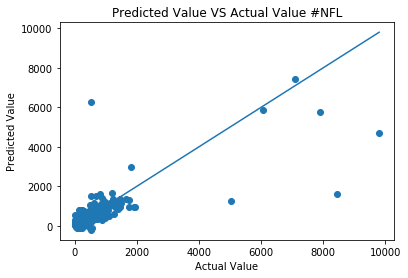

                            OLS Regression Results                            
Dep. Variable:                  tweet   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.577
Method:                 Least Squares   F-statistic:                     30.52
Date:                Sun, 22 Mar 2020   Prob (F-statistic):           5.88e-92
Time:                        14:15:50   Log-Likelihood:                -4477.9
No. Observations:                 586   AIC:                             9012.
Df Residuals:                     558   BIC:                             9134.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
tweet            0.5597      0.136      4.110   

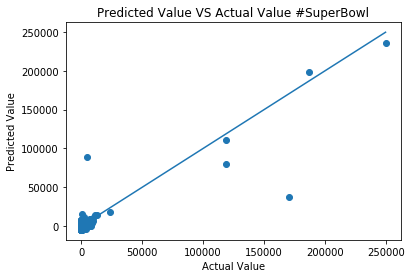

                            OLS Regression Results                            
Dep. Variable:                  tweet   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     87.65
Date:                Sun, 22 Mar 2020   Prob (F-statistic):          4.01e-181
Time:                        14:15:50   Log-Likelihood:                -6025.8
No. Observations:                 586   AIC:                         1.211e+04
Df Residuals:                     558   BIC:                         1.223e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
tweet            2.2820      0.081     28.230   

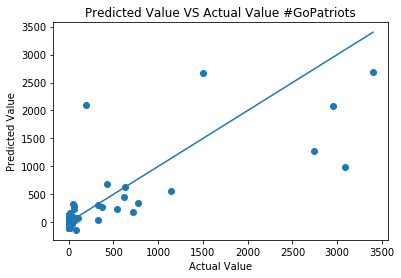

                            OLS Regression Results                            
Dep. Variable:                  tweet   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     38.32
Date:                Sun, 22 Mar 2020   Prob (F-statistic):          1.15e-108
Time:                        14:15:50   Log-Likelihood:                -3805.0
No. Observations:                 586   AIC:                             7666.
Df Residuals:                     558   BIC:                             7789.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
tweet            0.2981      0.285      1.046   

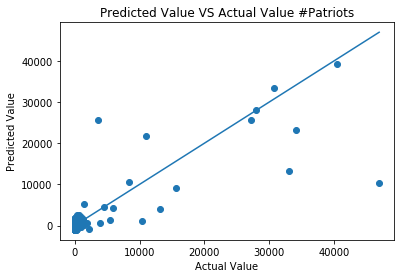

                            OLS Regression Results                            
Dep. Variable:                  tweet   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     44.53
Date:                Sun, 22 Mar 2020   Prob (F-statistic):          1.59e-120
Time:                        14:15:50   Log-Likelihood:                -5348.2
No. Observations:                 586   AIC:                         1.075e+04
Df Residuals:                     558   BIC:                         1.087e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
tweet            0.9198      0.072     12.834   

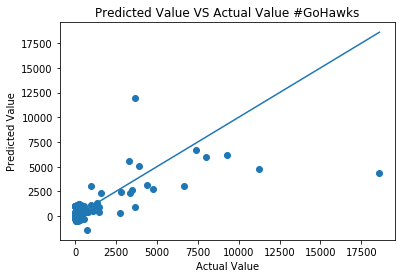

                            OLS Regression Results                            
Dep. Variable:                  tweet   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     21.48
Date:                Sun, 22 Mar 2020   Prob (F-statistic):           3.04e-69
Time:                        14:15:50   Log-Likelihood:                -4775.5
No. Observations:                 586   AIC:                             9607.
Df Residuals:                     558   BIC:                             9729.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
tweet            1.2478      0.165      7.584   

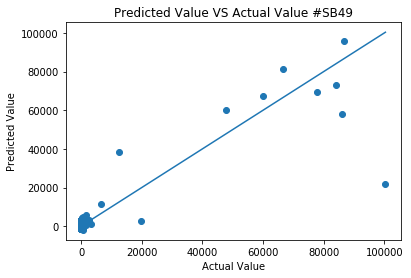

                            OLS Regression Results                            
Dep. Variable:                  tweet   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     89.31
Date:                Sun, 22 Mar 2020   Prob (F-statistic):          5.96e-183
Time:                        14:15:50   Log-Likelihood:                -5681.8
No. Observations:                 586   AIC:                         1.142e+04
Df Residuals:                     558   BIC:                         1.154e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
tweet            1.1201      0.089     12.560   

array([-8.03388235e+01, -4.40680584e+01, -2.53862945e+00,  1.67774495e+01,
       -1.88008862e+01,  1.20102676e+01,  1.55724525e+01, -1.01213745e+02,
       -4.51204641e+01,  6.08167697e+02,  3.24834186e+03, -4.14325906e+02,
       -7.78055715e+02, -5.14108713e+02,  1.12019730e+03,  3.61538987e+02,
        2.46617958e+02, -6.29515086e+02, -1.21154036e+03, -2.84031322e+02,
       -1.55018040e+02,  7.32504384e+01, -1.21688643e+02, -7.74106843e+01,
       -8.03388235e+01, -4.30217028e+01, -1.50079323e+00,  1.67774495e+01,
       -1.85760736e+01,  1.29904266e+01,  1.46017532e+01, -1.02066653e+02,
       -4.70966120e+01,  6.09263737e+02,  3.24834186e+03, -5.71494683e+02,
       -7.78055715e+02, -5.21614370e+02,  1.03160885e+03,  2.63346133e+02,
        2.50038912e+02, -6.28753852e+02, -1.21251994e+03, -3.06559695e+02,
       -1.91305151e+02,  1.93784958e+01, -1.73601612e+02, -7.74106843e+01,
       -8.03388235e+01, -4.40680584e+01, -1.49303627e+00,  1.67774495e+01,
       -1.96455393e+01,  

In [13]:
linear_regression(df_NFL, '#NFL')
linear_regression(df_Superbowl, '#SuperBowl')
linear_regression(df_GoPatriots, '#GoPatriots')
linear_regression(df_Patriots, '#Patriots')
linear_regression(df_GoHawks, '#GoHawks')
linear_regression(df_sb49, '#SB49')

## 1-3. Feature Analysis

In [14]:
def get_data_feature(hashtag):   
    dictionary = {'#GoHawks' : ['tweets_#gohawks.txt', sum(df_GoHawks.tweet)],
                    '#GoPatriots' : ['tweets_#gopatriots.txt', sum(df_GoPatriots.tweet)],
                    '#NFL' : ['tweets_#nfl.txt', sum(df_NFL.tweet)],
                    '#Patriots' : ['tweets_#patriots.txt', sum(df_Patriots.tweet)],
                    '#SB49' : ['tweets_#sb49.txt', sum(df_sb49.tweet)],
                    '#SuperBowl' : ['tweets_#superbowl.txt', sum(df_Superbowl.tweet)]}
    number_of_followers = []
    number_of_retweets = []
    day_of_tweet = []
    hour_of_tweet = []
    month_of_tweet = []
    time_stamp = []
    hashtags_in_tweet = np.zeros(dictionary[hashtag][1])
    reply = [False] * dictionary[hashtag][1]
    favorite_count = np.zeros(dictionary[hashtag][1])
    verified = [False] * dictionary[hashtag][1]
    number_of_citations = np.zeros(dictionary[hashtag][1])
    ranking_scores = np.zeros(dictionary[hashtag][1])
    #rank=[]
    pst_tz = pytz.timezone('America/Los_Angeles')
    file = open('./tweet_data/'+dictionary[hashtag][0],errors='ignore')
    # need to handle duplicates in users tweeting for actual number of users and for the number of followers
    authors = set()
    for (line, index) in zip(file, range(0, dictionary[hashtag][1])):
        data = json.loads(line)
        timestamp=(data['citation_date'])
        time_stamp.append(timestamp)
        timedata= datetime.datetime.fromtimestamp(timestamp,pst_tz)
        #ranktmp=100*timedata.month+timedata.day+0.01*timedata.hour
        #rank.append(ranktmp)
        day_of_tweet.append(timedata.day)
        hour_of_tweet.append(timedata.hour)
        month_of_tweet.append(timedata.month)
        number_of_retweets.append(data['metrics']['citations']['total'])
        hashtags_in_tweet[index] = data['title'].count('#')
        if data['tweet']['in_reply_to_status_id'] != 'null':
            reply[index] = True
        favorite_count[index] = data['tweet']['favorite_count']
        if data['tweet']['user']['verified'] != 'False':
            verified[index] = True
        number_of_citations[index] = len(data['tweet']['entities']['urls'])
        ranking_scores[index] = data['metrics']['ranking_score']
        if data['tweet']['user']['id'] not in authors:
            authors.add(data['tweet']['user']['id'])
        number_of_followers.append(data['author']['followers'])
    file.close()
    number_of_users = len(authors)
    total_hours=float(max(time_stamp)-min(time_stamp))/3600.0
    return month_of_tweet, day_of_tweet, hour_of_tweet, number_of_followers, number_of_retweets, number_of_users,hashtags_in_tweet, reply, favorite_count, verified, number_of_citations, ranking_scores

In [15]:
def process_data_feature(month,day,hour,followers,retweets,users,hashtags,reply,fav_cnt,verified,citations,ranking):
    monthsum=[month[0]]
    daysum=[day[0]]
    hoursum=[hour[0]]
    followersum=[followers[0]]
    retweetsum=[retweets[0]]
    tweetsum=[1]
    maxfollowers=[followers[0]]
    #new variables
    hashtagsum=[hashtags[0]]
    replysum=[np.multiply(reply[0], 1)]
    fav_cnt_sum=[fav_cnt[0]]
    verifiedsum=[np.multiply(verified[0], 1)]
    citationsum=[citations[0]]
    rankingsum=[ranking[0]]
    #End of new variables
    for i in range(len(day)):
        if i != 0:
            for j in (range(len(daysum))):
                if (month[i] == monthsum[j]) and (day[i] == daysum[j]) and (hour[i] == hoursum[j]):
                    followersum[j]=followersum[j]+followers[i]
                    retweetsum[j]=retweetsum[j]+retweets[i]
                    tweetsum[j]=tweetsum[j]+1
                    hashtagsum[j]=hashtagsum[j]+hashtags[i]
                    if reply[i] == True:
                        replysum[j]=replysum[j]+1
                    fav_cnt_sum[j]=fav_cnt_sum[j]+fav_cnt[i]
                    if verified[i] == True:
                        verifiedsum[j]=verifiedsum[j]+1
                    citationsum[j]=citationsum[j]+citations[i]
                    rankingsum[j]=rankingsum[j]+ranking[i]
                    if followers[i] > maxfollowers[j]:
                        maxfollowers[j]=followers[i]
                    break
                else:
                    if j == len(daysum)-1:
                        monthsum.append(month[i])
                        daysum.append(day[i])
                        hoursum.append(hour[i])
                        followersum.append(followers[i])
                        retweetsum.append(retweets[i])
                        tweetsum.append(1)
                        maxfollowers.append(followers[i])
                        hashtagsum.append(hashtags[i])
                        replysum.append(np.multiply(reply[i], 1))
                        fav_cnt_sum.append(fav_cnt[i])
                        verifiedsum.append(np.multiply(verified[0], 1))
                        citationsum.append(citations[0])
                        rankingsum.append(ranking[0])
    data={'month':monthsum,'day':daysum,'hour':hoursum,'follower':followersum,'retweet':retweetsum,'tweet':tweetsum,'Maxfollowers':maxfollowers,'Hashtag':hashtagsum,
         'reply':replysum,'favourite_count':fav_cnt_sum,'verified':verifiedsum,'citation':citationsum,'ranking':rankingsum}
    df = DataFrame(data)
    df=df.sort_values(by=['month','day','hour'])
    df=df.reset_index(drop=True)
    emptysum_feature=build_empty_feature(j)
    df=merge_feature(df,emptysum_feature)
    total_hour=len(df.tweet)
    return df,users,total_hour

In [16]:
def merge_feature (df,dfempty):
    df_new=dfempty
    for i in range(len(dfempty)):
        for j in range(len(df)):
            if df.month[j] == dfempty.month[i] and  df.day[j] == dfempty.day[i] and df.hour[j] == dfempty.hour[i]:
                df_new.follower[i] = df.follower[j]
                df_new.retweet[i] = df.retweet[j]
                df_new.tweet[i] = df.tweet[j]
                df_new.Maxfollowers[i] = df.Maxfollowers[j]
                df_new.Hashtag[i] = df.Hashtag[j]
                df_new.reply[i] = df.reply[j]
                df_new.favourite_count[i] = df.favourite_count[j]
                df_new.verified[i] = df.verified[j]
                df_new.citation[i] = df.citation[j]
                df_new.ranking[i] = df.ranking[j]
                break
    return df_new

In [17]:
#Build Empty matrix for feature
def build_empty_feature(j):
    d1 = datetime.datetime(2015, 1, 14, 0, 0)
    unixtime1 = time.mktime(d1.timetuple())
    d2 = datetime.datetime(2015, 2, 7, 10, 0)
    unixtime2 = time.mktime(d2.timetuple())
    timestampaxis=np.linspace(unixtime1,unixtime2,num=587)
    monthempty=[]
    dayempty=[]
    hourempty=[]
    pst_tz = pytz.timezone('America/Los_Angeles')
    for i in range(len(timestampaxis)):
        timedata=datetime.datetime.fromtimestamp(timestampaxis[i],pst_tz)
        monthempty.append(timedata.month)
        dayempty.append(timedata.day)
        hourempty.append(timedata.hour)
    data={'month':monthempty,'day':dayempty,'hour':hourempty,'tweet':[0]*len(timestampaxis),'follower':[0]*len(timestampaxis),'retweet':[0]*len(timestampaxis),'Maxfollowers':[0]*len(timestampaxis),
          'Hashtag':[0]*len(timestampaxis),'reply':[0]*len(timestampaxis),'favourite_count':[0]*len(timestampaxis),'verified':[0]*len(timestampaxis),'citation':[0]*len(timestampaxis),'ranking':[0]*len(timestampaxis)}
    emptysum_feature=DataFrame(data)
    return emptysum_feature

### 4. & 5.

4. Design a regression model using any features from the papers you find or other new features you may find useful for this problem. Fit your model on the data of each hashtag and report fitting MSE and significance of features.

5. For each of the top 3 features (i.e. with the smallest p-values) in your measurements, draw a scatter plot of predictant (number of tweets for next hour) versus value of that feature, using all the samples you have extracted, and analyze it. Do the regression coefficients agree with the trends in the plots? If not, why?

#### i) NFL

RMSE is: 394.5126755879352


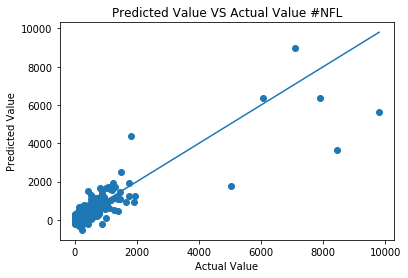

                            OLS Regression Results                            
Dep. Variable:                  tweet   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     54.36
Date:                Sun, 22 Mar 2020   Prob (F-statistic):          1.80e-146
Time:                        14:16:29   Log-Likelihood:                -4334.4
No. Observations:                 586   AIC:                             8733.
Df Residuals:                     554   BIC:                             8873.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
tweet              -0.7247      0.510     

In [18]:
month,day,hour,followers,retweets,users,hashtags,reply,fav_cnt,verified,citations,ranking=get_data_feature('#NFL')
df_NFL_feature,user_NFL_feature,total_hour_NFL_feature=process_data_feature(month,day,hour,followers,retweets,users,hashtags,reply,fav_cnt,verified,citations,ranking)
predicted_NFL_feature=linear_regression(df_NFL_feature, '#NFL')

The top three features are favourite count, Hashtag Number and Citation Number (with the smallest p-values).

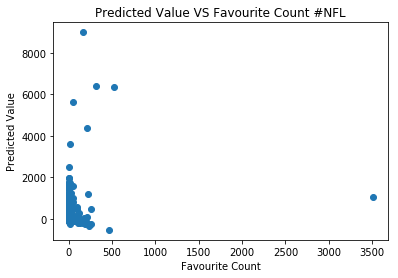

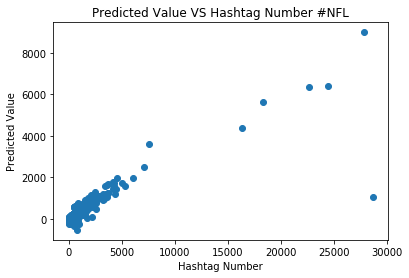

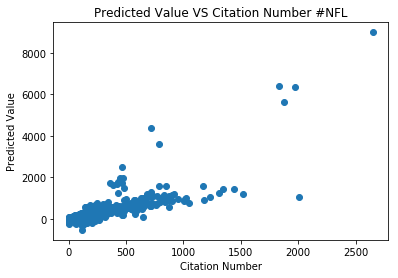

In [19]:
df_NFL_feature_drop=df_NFL_feature.drop([len(df_NFL_feature.tweet)-1])
plt.scatter(df_NFL_feature_drop.favourite_count, predicted_NFL_feature)
plt.xlabel('Favourite Count')
plt.ylabel('Predicted Value')
plt.title('Predicted Value VS Favourite Count ' + str('#NFL'))
plt.show()
plt.scatter(df_NFL_feature_drop.Hashtag, predicted_NFL_feature)
plt.xlabel('Hashtag Number')
plt.ylabel('Predicted Value')
plt.title('Predicted Value VS Hashtag Number ' + str('#NFL'))
plt.show()
plt.scatter(df_NFL_feature_drop.citation, predicted_NFL_feature)
plt.xlabel('Citation Number')
plt.ylabel('Predicted Value')
plt.title('Predicted Value VS Citation Number ' + str('#NFL'))
plt.show()

#### ii) GoHawks

RMSE is: 700.8128346896752


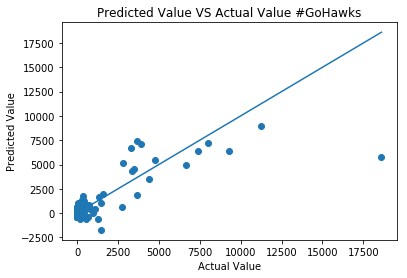

                            OLS Regression Results                            
Dep. Variable:                  tweet   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     34.17
Date:                Sun, 22 Mar 2020   Prob (F-statistic):          6.88e-108
Time:                        14:16:54   Log-Likelihood:                -4671.1
No. Observations:                 586   AIC:                             9406.
Df Residuals:                     554   BIC:                             9546.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
tweet             -12.8481      1.273    -

In [20]:
month,day,hour,followers,retweets,users,hashtags,reply,fav_cnt,verified,citations,ranking=get_data_feature('#GoHawks')
df_GoHawks_feature,user_GoHawks_feature,total_hour_GoHawks_feature=process_data_feature(month,day,hour,followers,retweets,users,hashtags,reply,fav_cnt,verified,citations,ranking)
predicted_GoHawks_feature=linear_regression(df_GoHawks_feature, '#GoHawks')

The top three features are Number of tweets, Number of Reply and Number of Verified User

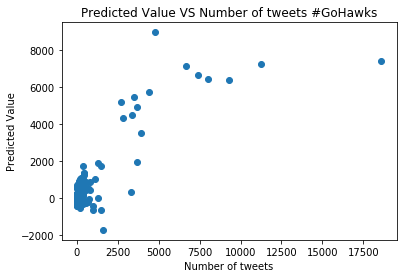

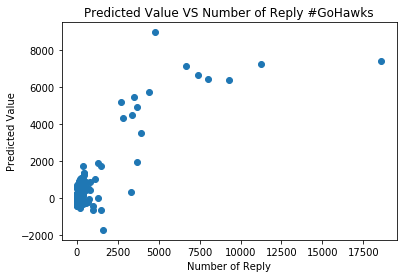

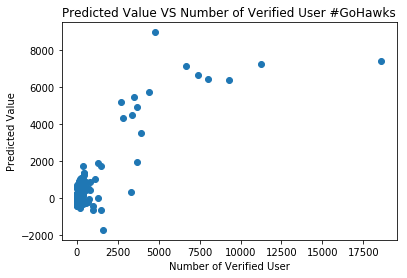

In [21]:
df_GoHawks_feature_drop=df_GoHawks_feature.drop([len(df_GoHawks_feature.tweet)-1])
plt.scatter(df_GoHawks_feature_drop.tweet, predicted_GoHawks_feature)
plt.xlabel('Number of tweets')
plt.ylabel('Predicted Value')
plt.title('Predicted Value VS Number of tweets ' + str('#GoHawks'))
plt.show()
plt.scatter(df_GoHawks_feature_drop.reply, predicted_GoHawks_feature)
plt.xlabel('Number of Reply')
plt.ylabel('Predicted Value')
plt.title('Predicted Value VS Number of Reply ' + str('#GoHawks'))
plt.show()
plt.scatter(df_GoHawks_feature_drop.verified, predicted_GoHawks_feature)
plt.xlabel('Number of Verified User')
plt.ylabel('Predicted Value')
plt.title('Predicted Value VS Number of Verified User ' + str('#GoHawks'))
plt.show()

#### iii) GoPatriots

RMSE is: 105.96317320325763


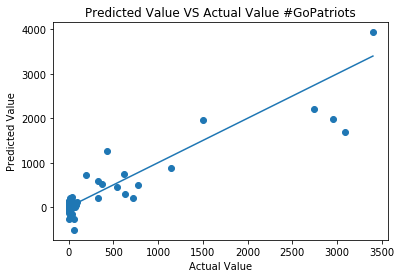

                            OLS Regression Results                            
Dep. Variable:                  tweet   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     98.22
Date:                Sun, 22 Mar 2020   Prob (F-statistic):          8.13e-203
Time:                        14:17:03   Log-Likelihood:                -3564.1
No. Observations:                 586   AIC:                             7192.
Df Residuals:                     554   BIC:                             7332.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
tweet              -8.8131      0.681    -

In [22]:
month,day,hour,followers,retweets,users,hashtags,reply,fav_cnt,verified,citations,ranking=get_data_feature('#GoPatriots')
df_GoPatriots_feature,user_GoPatriots_feature,total_hour_GoPatriots_feature=process_data_feature(month,day,hour,followers,retweets,users,hashtags,reply,fav_cnt,verified,citations,ranking)
predicted_GoPatriots_feature=linear_regression(df_GoPatriots_feature, '#GoPatriots')

The top three features we choose are Number of tweets, Number of Reply and Number of verified User.

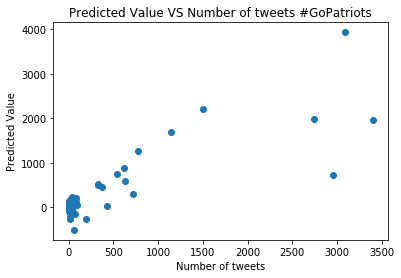

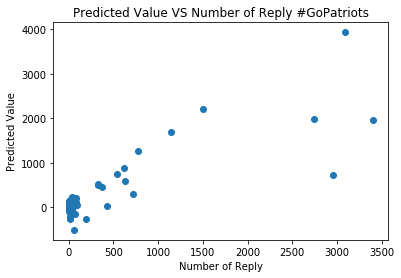

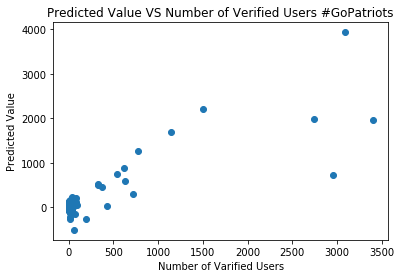

In [23]:
df_GoPatriots_feature_drop=df_GoPatriots_feature.drop([len(df_GoPatriots_feature.tweet)-1])
plt.scatter(df_GoPatriots_feature_drop.tweet, predicted_GoPatriots_feature)
plt.xlabel('Number of tweets')
plt.ylabel('Predicted Value')
plt.title('Predicted Value VS Number of tweets ' + str('#GoPatriots'))
plt.show()
plt.scatter(df_GoPatriots_feature_drop.reply, predicted_GoPatriots_feature)
plt.xlabel('Number of Reply')
plt.ylabel('Predicted Value')
plt.title('Predicted Value VS Number of Reply ' + str('#GoPatriots'))
plt.show()
plt.scatter(df_GoPatriots_feature_drop.verified, predicted_GoPatriots_feature)
plt.xlabel('Number of Varified Users')
plt.ylabel('Predicted Value')
plt.title('Predicted Value VS Number of Verified Users ' + str('#GoPatriots'))
plt.show()

#### iv) Patriots

RMSE is: 1752.4304812464936


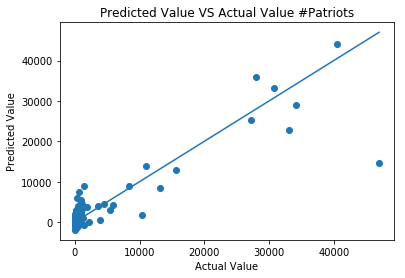

                            OLS Regression Results                            
Dep. Variable:                  tweet   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     73.06
Date:                Sun, 22 Mar 2020   Prob (F-statistic):          9.55e-174
Time:                        14:18:05   Log-Likelihood:                -5208.2
No. Observations:                 586   AIC:                         1.048e+04
Df Residuals:                     554   BIC:                         1.062e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
tweet             -18.1945      1.629    -

In [24]:
month,day,hour,followers,retweets,users,hashtags,reply,fav_cnt,verified,citations,ranking=get_data_feature('#Patriots')
df_Patriots_feature,user_Patriots_feature,total_hour_Patriots_feature=process_data_feature(month,day,hour,followers,retweets,users,hashtags,reply,fav_cnt,verified,citations,ranking)
predicted_Patriots_feature=linear_regression(df_Patriots_feature, '#Patriots')

The top three features we choose are Number of tweets, Number of retweet and Number of verified users

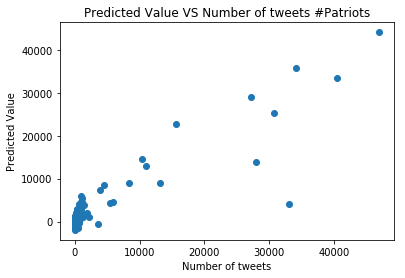

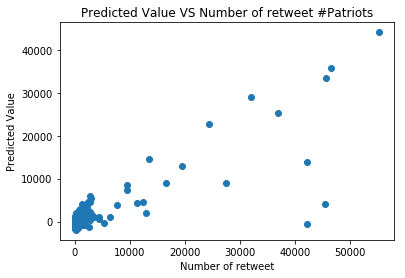

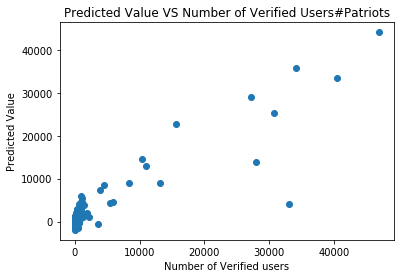

In [25]:
df_Patriots_feature_drop=df_Patriots_feature.drop([len(df_Patriots_feature.tweet)-1])
plt.scatter(df_Patriots_feature_drop.tweet, predicted_Patriots_feature)
plt.xlabel('Number of tweets')
plt.ylabel('Predicted Value')
plt.title('Predicted Value VS Number of tweets ' + str('#Patriots'))
plt.show()
plt.scatter(df_Patriots_feature_drop.retweet, predicted_Patriots_feature)
plt.xlabel('Number of retweet')
plt.ylabel('Predicted Value')
plt.title('Predicted Value VS Number of retweet ' + str('#Patriots'))
plt.show()
plt.scatter(df_Patriots_feature_drop.verified, predicted_Patriots_feature)
plt.xlabel('Number of Verified users')
plt.ylabel('Predicted Value')
plt.title('Predicted Value VS Number of Verified Users' + str('#Patriots'))
plt.show()

#### v) Superbowl 

RMSE is: 5285.694572972141


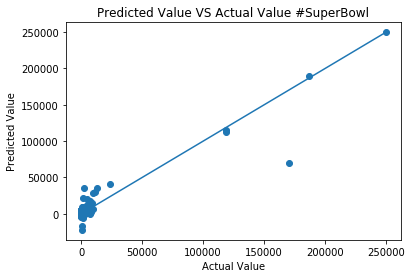

                            OLS Regression Results                            
Dep. Variable:                  tweet   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     151.1
Date:                Sun, 22 Mar 2020   Prob (F-statistic):          1.21e-247
Time:                        14:20:45   Log-Likelihood:                -5852.9
No. Observations:                 586   AIC:                         1.177e+04
Df Residuals:                     554   BIC:                         1.191e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
tweet             -13.1188      1.340     

In [26]:
month,day,hour,followers,retweets,users,hashtags,reply,fav_cnt,verified,citations,ranking=get_data_feature('#SuperBowl')
df_SuperBowl_feature,user_SuperBowl_feature,total_hour_SuperBowl_feature=process_data_feature(month,day,hour,followers,retweets,users,hashtags,reply,fav_cnt,verified,citations,ranking)
predicted_SuperBowl_feature=linear_regression(df_SuperBowl_feature, '#SuperBowl')

The top three features we choose are Number of Hashtag, Number of Reply and Number of Verified Users.

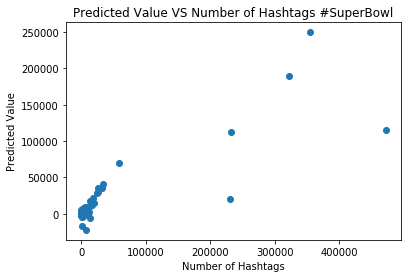

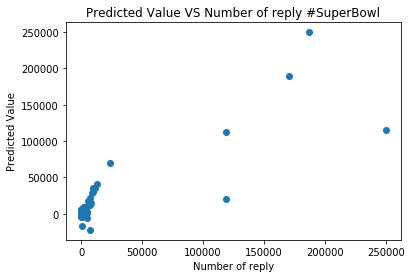

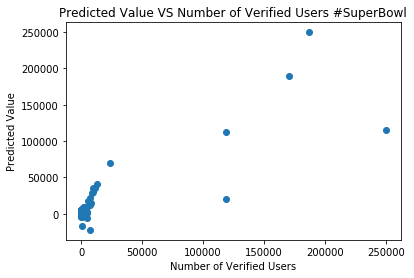

In [27]:
df_SuperBowl_feature_drop=df_SuperBowl_feature.drop([len(df_SuperBowl_feature.tweet)-1])
plt.scatter(df_SuperBowl_feature_drop.Hashtag, predicted_SuperBowl_feature)
plt.xlabel('Number of Hashtags')
plt.ylabel('Predicted Value')
plt.title('Predicted Value VS Number of Hashtags ' + str('#SuperBowl'))
plt.show()
plt.scatter(df_SuperBowl_feature_drop.reply, predicted_SuperBowl_feature)
plt.xlabel('Number of reply')
plt.ylabel('Predicted Value')
plt.title('Predicted Value VS Number of reply ' + str('#SuperBowl'))
plt.show()
plt.scatter(df_SuperBowl_feature_drop.verified, predicted_SuperBowl_feature)
plt.xlabel('Number of Verified Users')
plt.ylabel('Predicted Value')
plt.title('Predicted Value VS Number of Verified Users ' + str('#SuperBowl'))
plt.show()

#### vi) SB49

RMSE is: 3689.5291092083216


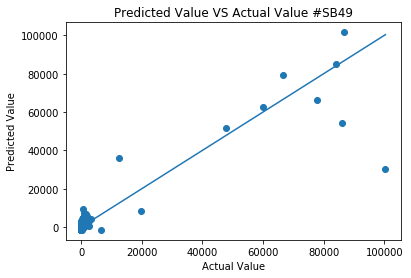

                            OLS Regression Results                            
Dep. Variable:                  tweet   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     90.16
Date:                Sun, 22 Mar 2020   Prob (F-statistic):          3.04e-194
Time:                        14:22:25   Log-Likelihood:                -5644.5
No. Observations:                 586   AIC:                         1.135e+04
Df Residuals:                     554   BIC:                         1.149e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
tweet             -14.3152      2.978     

In [28]:
month,day,hour,followers,retweets,users,hashtags,reply,fav_cnt,verified,citations,ranking=get_data_feature('#SB49')
df_SB49_feature,user_SB49_feature,total_hour_SB49_feature=process_data_feature(month,day,hour,followers,retweets,users,hashtags,reply,fav_cnt,verified,citations,ranking)
predicted_SB49_feature=linear_regression(df_SB49_feature, '#SB49')

The top three features we choose are Number of citation, Number of reply and Number of Verified Users.

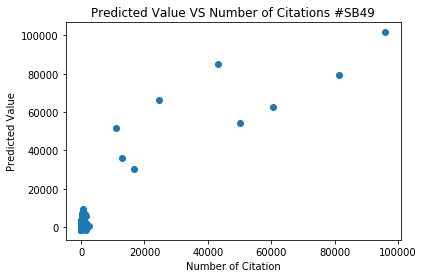

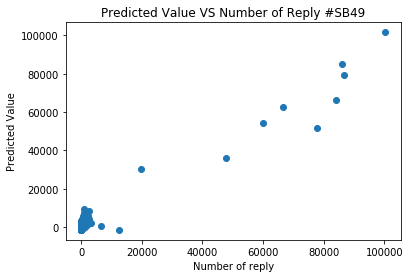

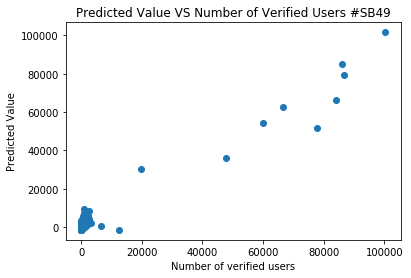

In [29]:
df_SB49_feature_drop=df_SB49_feature.drop([len(df_SB49_feature.tweet)-1])
plt.scatter(df_SB49_feature_drop.citation, predicted_SB49_feature)
plt.xlabel('Number of Citation')
plt.ylabel('Predicted Value')
plt.title('Predicted Value VS Number of Citations ' + str('#SB49'))
plt.show()
plt.scatter(df_SB49_feature_drop.reply, predicted_SB49_feature)
plt.xlabel('Number of reply')
plt.ylabel('Predicted Value')
plt.title('Predicted Value VS Number of Reply ' + str('#SB49'))
plt.show()
plt.scatter(df_SB49_feature_drop.verified, predicted_SB49_feature)
plt.xlabel('Number of verified users')
plt.ylabel('Predicted Value')
plt.title('Predicted Value VS Number of Verified Users ' + str('#SB49'))
plt.show()

### 1-4. Piecewise Linear Regression

Since we know the Super Bowl's date and time, we can create different regression models for
different periods of time. First, when the hashtags haven't become very active; second, their
active period; and third, after they pass their high-activity time.

In [30]:
def get_data_piece(hashtag):   
    dictionary = {'#GoHawks': 'tweets_#gohawks.txt',
                     '#GoPatriots': 'tweets_#gopatriots.txt',
                  '#Patriots': 'tweets_#patriots.txt',
                     '#NFL': 'tweets_#nfl.txt',
                     '#SB49': 'tweets_#sb49.txt',
                     '#SuperBowl': 'tweets_#superbowl.txt'}
    number_of_followers = []
    number_of_retweets = []
    day_of_tweet = []
    hour_of_tweet = []
    month_of_tweet = []
    time_stamp = []
    min_of_tweet = []
    #rank=[]
    pst_tz = pytz.timezone('America/Los_Angeles')
    file = open('./tweet_data/'+dictionary[hashtag],errors='ignore')
    # need to handle duplicates in users tweeting for actual number of users and for the number of followers
    authors = set()
    for line in file:
        data = json.loads(line)
        timestamp=(data['citation_date'])
        timedata= datetime.datetime.fromtimestamp(timestamp,pst_tz)
        #ranktmp=100*timedata.month+timedata.day+0.01*timedata.hour
        #rank.append(ranktmp)
        if (timedata.day == 1 and timedata.hour >=8) and (timedata.day == 1 and timedata.hour <20):
            day_of_tweet.append(timedata.day)
            hour_of_tweet.append(timedata.hour)
            month_of_tweet.append(timedata.month)
            min_of_tweet.append(timedata.minute)
            number_of_retweets.append(data['metrics']['citations']['total'])
            if data['tweet']['user']['id'] not in authors:
                authors.add(data['tweet']['user']['id'])
            number_of_followers.append(data['author']['followers'])
    file.close()
    number_of_users = len(authors)
    return month_of_tweet, day_of_tweet, hour_of_tweet, min_of_tweet, number_of_followers, number_of_retweets, number_of_users

In [31]:
def process_data_piece(month,day,hour,minute,followers,retweets,users):
    monthsum=[month[0]]
    daysum=[day[0]]
    hoursum=[hour[0]]
    minsum=[minute[0]]
    followersum=[followers[0]]
    retweetsum=[retweets[0]]
    tweetsum=[1]
    maxfollowers=[followers[0]]
    for i in range(len(day)):
        if i != 0:
                for j in (range(len(daysum))):
                    if (month[i] == monthsum[j]) and (day[i] == daysum[j]) and (hour[i] == hoursum[j]) and (minute[i] == minsum[j]):
                        followersum[j]=followersum[j]+followers[i]
                        retweetsum[j]=retweetsum[j]+retweets[i]
                        tweetsum[j]=tweetsum[j]+1
                        if followers[i] > maxfollowers[j]:
                            maxfollowers[j]=followers[i]
                        break
                    else:
                        if j == len(daysum)-1:
                            monthsum.append(month[i])
                            minsum.append(minute[i])
                            daysum.append(day[i])
                            hoursum.append(hour[i])
                            followersum.append(followers[i])
                            retweetsum.append(retweets[i])
                            tweetsum.append(1)
                            maxfollowers.append(followers[i])
    data={'month':monthsum,'day':daysum,'hour':hoursum,'minute':minsum,'follower':followersum,'retweet':retweetsum,'tweet':tweetsum,'Maxfollowers':maxfollowers}
    df = DataFrame(data)
    df=df.sort_values(by=['month','day','hour','minute'])
    df=df.reset_index(drop=True)
    emptysum_minute=build_empty_minute(j)
    df=merge_minute(df,emptysum_minute)
    total_hour=len(df.tweet)
    return df

In [32]:
def cut_piece (df):
    
    for i in range(len(df)):
        if df.month[i] == 2 and df.hour[i] == 8:
            break
    df1=df[0:i]
    
    for j in range(len(df)):
        if df.day[j] == 1 and df.hour[j] ==20:
            break
    df3=df[j:len(df.month)]
    df3=df3.reset_index(drop=True)
    return df1,df3

In [33]:
def linear_regression_minute(data_frame, hashtag):
    #need to one hot encode time of day
    training_data = one_hot(data_frame, ['hour','minute'])
    training_data.drop('hour', 1, inplace=True)
    training_data.drop('day', 1, inplace=True)
    training_data.drop('month', 1, inplace=True)
    training_data.drop('minute', 1, inplace=True)
    target_data = training_data.tweet[1:]
    target_data=target_data.reset_index(drop=True)
    #print(target_data)
    training_data=training_data.drop([len(training_data.tweet)-1])
    #print(training_data)
    linear_reg = LinearRegression(fit_intercept = False)
    linear_regression_fitted = linear_reg.fit(training_data, target_data)
    
    predicted = linear_regression_fitted.predict(training_data)
    RMSE = calculate_RMSE(predicted, target_data)
    print('RMSE is:', RMSE)
    plot_LIN(target_data, predicted, hashtag)
    perform_t_test(target_data, training_data)
    return predicted

In [34]:
def merge_minute (df,dfempty):
    df_new = dfempty
    for i in range(len(dfempty)):
        for j in range(len(df)):
            if df.month[j] == dfempty.month[i] and  df.day[j] == dfempty.day[i] and df.hour[j] == dfempty.hour[i] and df.minute[j] == dfempty.minute[i]:
                df_new.follower[i] = df.follower[j]
                df_new.retweet[i] = df.retweet[j]
                df_new.tweet[i] = df.tweet[j]
                df_new.Maxfollowers[i] = df.Maxfollowers[j]
                break
    return df_new

In [35]:
#Build Empty matrix
def build_empty_minute(j):
    d1 = datetime.datetime(2015, 2, 1, 8, 0)
    unixtime1 = time.mktime(d1.timetuple())
    d2 = datetime.datetime(2015, 2, 1, 20, 0)
    unixtime2 = time.mktime(d2.timetuple())
    # 145 intervals = 12 5-min blocks * 12 hrs + 1
    timestampaxis=np.linspace(unixtime1,unixtime2,num=145)
    monthempty=[]
    dayempty=[]
    hourempty=[]
    minuteempty=[]
    pst_tz = pytz.timezone('America/Los_Angeles')
    
    for i in range(len(timestampaxis)):
        timedata=datetime.datetime.fromtimestamp(timestampaxis[i],pst_tz)
        monthempty.append(timedata.month)
        dayempty.append(timedata.day)
        hourempty.append(timedata.hour)
        minuteempty.append(math.ceil((timedata.minute)/5))
        
    data={'month':monthempty,'day':dayempty,'hour':hourempty,'minute':minuteempty,'tweet':[0]*len(timestampaxis),'follower':[0]*len(timestampaxis),'retweet':[0]*len(timestampaxis),'Maxfollowers':[0]*len(timestampaxis)}
    emptysum_minute=DataFrame(data)
    
    return emptysum_minute

### 6.

For each hashtag, train 3 regression models, one for each of these time periods (the times are all in PST). Report the MSE and R-squared score for each case.

#### (i) NFL

In [36]:
month_of_tweet, day_of_tweet, hour_of_tweet, min_of_tweet, number_of_followers, number_of_retweets, number_of_users = get_data_piece('#NFL')
df_NFL_piece2 = process_data_piece(month_of_tweet, day_of_tweet, hour_of_tweet, min_of_tweet, number_of_followers, number_of_retweets, number_of_users)
df_NFL_piece1, df_NFL_piece3 = cut_piece(df_NFL)

RMSE is: 248.8577827345286


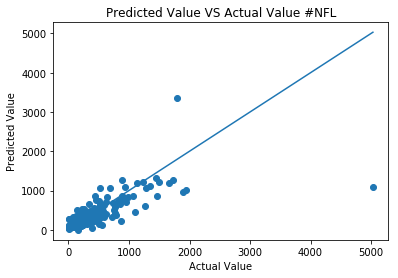

                            OLS Regression Results                            
Dep. Variable:                  tweet   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     17.96
Date:                Sun, 22 Mar 2020   Prob (F-statistic):           9.91e-54
Time:                        14:22:50   Log-Likelihood:                -3044.8
No. Observations:                 439   AIC:                             6146.
Df Residuals:                     411   BIC:                             6260.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
tweet            0.4769      0.102      4.665   

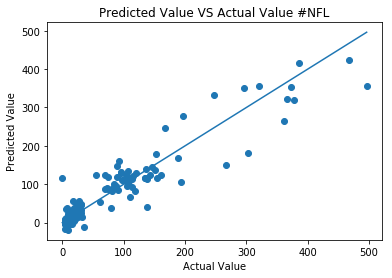

                            OLS Regression Results                            
Dep. Variable:                  tweet   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     33.02
Date:                Sun, 22 Mar 2020   Prob (F-statistic):           3.41e-42
Time:                        14:22:50   Log-Likelihood:                -713.59
No. Observations:                 144   AIC:                             1481.
Df Residuals:                     117   BIC:                             1561.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
tweet            0.5818      0.129      4.516   

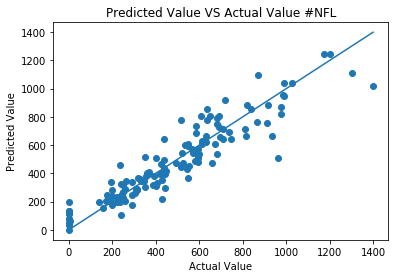

                            OLS Regression Results                            
Dep. Variable:                  tweet   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     24.31
Date:                Sun, 22 Mar 2020   Prob (F-statistic):           5.67e-34
Time:                        14:22:50   Log-Likelihood:                -819.02
No. Observations:                 134   AIC:                             1694.
Df Residuals:                     106   BIC:                             1775.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
tweet            0.8436      0.116      7.284   

array([ 458.65293632,  218.62607652,  288.12794663,  206.31341451,
        154.33178537,  178.55327558,  203.3785582 ,  215.25806699,
        233.01792092,  320.69519412,  327.48070188,  339.44895698,
        282.30393769,  341.10023366,  506.17230707, 1018.21360963,
       1242.04435684, 1107.20133256, 1244.57916456, 1036.99847386,
        857.7927577 ,  823.69011505,  747.85852332,  717.69415562,
        631.17514649,  543.63519167,  414.87131996,  383.92959323,
        301.34380289,  346.55712095,  312.95076076,  418.29562625,
        452.12731088,  606.9182169 ,  693.63335026,  766.94678922,
        884.34395217,  866.44016234, 1093.2745151 ,  949.01632786,
        883.79394184,  805.26803064,  667.41980844,  791.36169072,
        619.595978  ,  642.46446023,  284.02849714,  295.71694965,
        397.78953843,  401.16486192,  233.67206628,  176.00452863,
        246.27138173,  197.9702969 ,  226.9105201 ,  291.33741575,
        344.17810437,  438.10369351,  483.58157768,  643.28854

In [37]:
linear_regression(df_NFL_piece1,'#NFL')
linear_regression_minute(df_NFL_piece2,'#NFL')
linear_regression(df_NFL_piece3,'#NFL')

#### (ii) GoHawks

In [38]:
month_of_tweet, day_of_tweet, hour_of_tweet, min_of_tweet, number_of_followers, number_of_retweets, number_of_users=get_data_piece('#GoHawks')
df_GoHawks_piece2=process_data_piece(month_of_tweet, day_of_tweet, hour_of_tweet, min_of_tweet, number_of_followers, number_of_retweets, number_of_users)
df_GoHawks_piece1,df_GoHawks_piece3=cut_piece(df_GoHawks)

RMSE is: 816.6104179136739


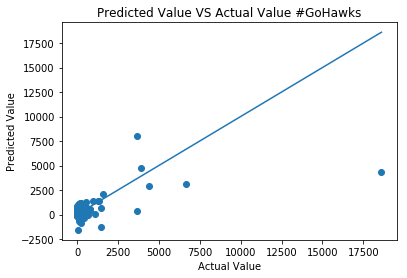

                            OLS Regression Results                            
Dep. Variable:                  tweet   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     8.311
Date:                Sun, 22 Mar 2020   Prob (F-statistic):           2.36e-25
Time:                        14:23:10   Log-Likelihood:                -3566.5
No. Observations:                 439   AIC:                             7189.
Df Residuals:                     411   BIC:                             7303.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
tweet            2.2386      0.295      7.592   

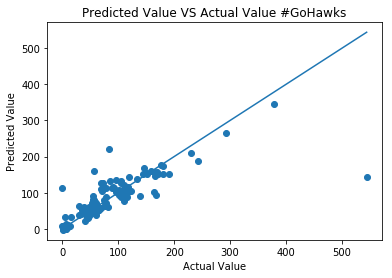

                            OLS Regression Results                            
Dep. Variable:                  tweet   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                     8.286
Date:                Sun, 22 Mar 2020   Prob (F-statistic):           2.11e-16
Time:                        14:23:10   Log-Likelihood:                -743.62
No. Observations:                 144   AIC:                             1541.
Df Residuals:                     117   BIC:                             1621.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
tweet            0.4491      0.186      2.410   

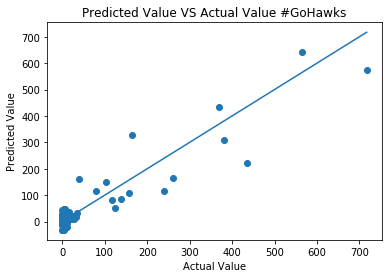

                            OLS Regression Results                            
Dep. Variable:                  tweet   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     23.75
Date:                Sun, 22 Mar 2020   Prob (F-statistic):           1.56e-33
Time:                        14:23:10   Log-Likelihood:                -679.49
No. Observations:                 134   AIC:                             1415.
Df Residuals:                     106   BIC:                             1496.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
tweet            0.1750      0.119      1.468   

array([641.03028206, 572.96285287, 435.2153509 , 329.15317867,
        80.63674185, 114.00054847, 151.59642168,  52.40380596,
        85.2328485 , 108.37703909, 116.48273414, 165.76792109,
       220.46735242, 307.70786491, 162.48272665,  34.2878698 ,
        20.47775298,   9.34784606,  16.95515918,  18.57400761,
         9.66631581,  11.97202631,   8.39152321,  10.25375012,
        -6.47810376,  36.52367635,  -7.51259545, -31.14034163,
         8.40524693,  -5.6273532 ,  -8.77540448,  15.14777694,
        12.39022591,  10.94031058,  29.17616   ,  26.45053465,
        47.59391557,  18.80757565, -21.49071098,   8.58204226,
         9.32672514,  12.88314816,   9.64221921,   8.09942789,
         7.36745222,   6.13126543,   3.83067578,   4.84263084,
       -11.15554638,  32.76387079, -12.24181963, -31.49438021,
         8.63441346,  -5.05792976,  -9.37612271,  15.14818841,
        12.24595306,  11.22656088,  29.0587614 ,  22.30062665,
        47.76131506,  20.00595537, -25.21307509,   8.97

In [39]:
linear_regression(df_GoHawks_piece1,'#GoHawks')
linear_regression_minute(df_GoHawks_piece2,'#GoHawks')
linear_regression(df_GoHawks_piece3,'#GoHawks')

#### (iii) GoPatriots

In [40]:
month_of_tweet, day_of_tweet, hour_of_tweet, min_of_tweet, number_of_followers, number_of_retweets, number_of_users=get_data_piece('#GoPatriots')
df_GoPatriots_piece2=process_data_piece(month_of_tweet, day_of_tweet, hour_of_tweet, min_of_tweet, number_of_followers, number_of_retweets, number_of_users)
df_GoPatriots_piece1,df_GoPatriots_piece3=cut_piece(df_GoPatriots)

RMSE is: 40.45812675770317


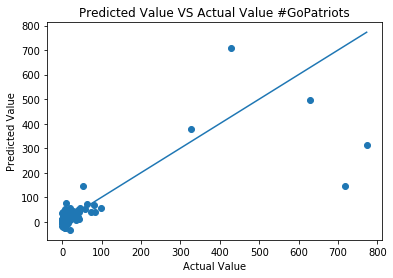

                            OLS Regression Results                            
Dep. Variable:                  tweet   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     22.83
Date:                Sun, 22 Mar 2020   Prob (F-statistic):           2.15e-65
Time:                        14:23:17   Log-Likelihood:                -2247.3
No. Observations:                 439   AIC:                             4551.
Df Residuals:                     411   BIC:                             4665.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
tweet            1.8682      0.187      9.979   

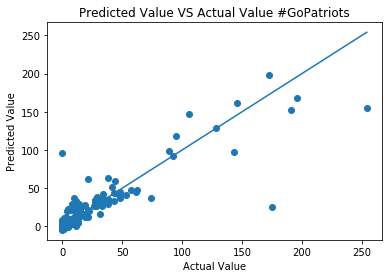

                            OLS Regression Results                            
Dep. Variable:                  tweet   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     15.00
Date:                Sun, 22 Mar 2020   Prob (F-statistic):           2.97e-26
Time:                        14:23:17   Log-Likelihood:                -638.01
No. Observations:                 144   AIC:                             1330.
Df Residuals:                     117   BIC:                             1410.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
tweet            0.5648      0.175      3.220   

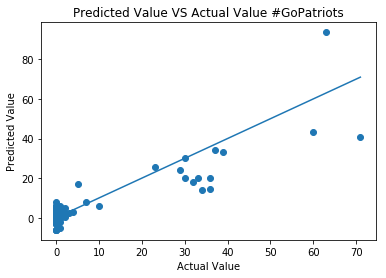

                            OLS Regression Results                            
Dep. Variable:                  tweet   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     14.09
Date:                Sun, 22 Mar 2020   Prob (F-statistic):           3.82e-24
Time:                        14:23:17   Log-Likelihood:                -429.73
No. Observations:                 134   AIC:                             915.5
Df Residuals:                     106   BIC:                             996.6
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
tweet            0.8763      0.166      5.288   

array([ 9.36599776e+01,  4.31780392e+01,  4.10163174e+01,  3.31421459e+01,
        3.03252865e+01,  2.02211584e+01,  1.82969601e+01,  2.01979006e+01,
        1.99643765e+01,  3.42372256e+01,  2.41096709e+01,  1.39022395e+01,
        1.43048373e+01,  2.54006037e+01,  1.68664632e+01,  5.79964867e+00,
        8.11637049e+00,  2.65124157e+00,  1.88341989e+00,  2.25033748e+00,
        2.95849097e+00,  3.02695805e+00, -1.59587733e-01,  9.25237680e-01,
       -5.20642003e+00,  4.77271295e+00,  8.05033178e+00,  1.19051476e+00,
       -7.25468359e-02,  1.86205328e+00,  3.83777227e+00,  2.76041989e+00,
        3.12458622e+00,  4.99376814e-01,  2.14888993e+00,  5.04072725e+00,
        4.34978463e+00, -2.77560484e-01, -2.13592528e+00,  2.65595294e+00,
       -3.20890084e-01,  5.51587687e-02,  2.91450283e-02,  4.37415631e-01,
        2.81523616e-01,  4.24754288e-01,  1.63835093e+00,  1.86905800e-02,
       -6.11338939e+00,  3.51231197e+00,  5.73333770e+00,  1.19051476e+00,
        9.64900866e-01,  

In [41]:
linear_regression(df_GoPatriots_piece1,'#GoPatriots')
linear_regression_minute(df_GoPatriots_piece2,'#GoPatriots')
linear_regression(df_GoPatriots_piece3,'#GoPatriots')

#### (iv) Patriots

In [42]:
month_of_tweet, day_of_tweet, hour_of_tweet, min_of_tweet, number_of_followers, number_of_retweets, number_of_users=get_data_piece('#Patriots')
df_Patriots_piece2=process_data_piece(month_of_tweet, day_of_tweet, hour_of_tweet, min_of_tweet, number_of_followers, number_of_retweets, number_of_users)
df_Patriots_piece1,df_Patriots_piece3=cut_piece(df_Patriots)

RMSE is: 570.2522769682934


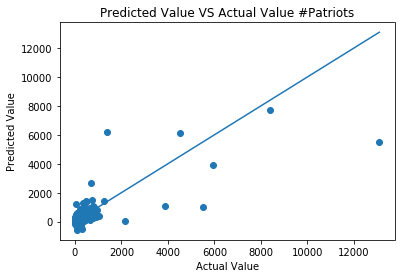

                            OLS Regression Results                            
Dep. Variable:                  tweet   R-squared:                       0.584
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     21.35
Date:                Sun, 22 Mar 2020   Prob (F-statistic):           5.25e-62
Time:                        14:24:13   Log-Likelihood:                -3408.8
No. Observations:                 439   AIC:                             6874.
Df Residuals:                     411   BIC:                             6988.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
tweet           -0.2326      0.193     -1.204   

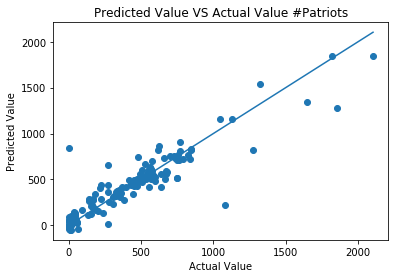

                            OLS Regression Results                            
Dep. Variable:                  tweet   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     23.80
Date:                Sun, 22 Mar 2020   Prob (F-statistic):           2.93e-35
Time:                        14:24:13   Log-Likelihood:                -928.63
No. Observations:                 144   AIC:                             1911.
Df Residuals:                     117   BIC:                             1991.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
tweet            0.0715      0.192      0.372   

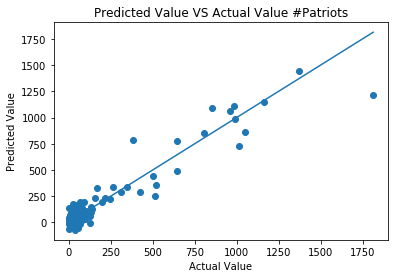

                            OLS Regression Results                            
Dep. Variable:                  tweet   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     36.14
Date:                Sun, 22 Mar 2020   Prob (F-statistic):           8.75e-42
Time:                        14:24:14   Log-Likelihood:                -798.75
No. Observations:                 134   AIC:                             1654.
Df Residuals:                     106   BIC:                             1735.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
tweet            0.7776      0.096      8.114   

array([ 1.44069871e+03,  1.21896068e+03,  1.06432211e+03,  7.71463624e+02,
        3.52636077e+02,  4.41033572e+02,  4.93001689e+02,  8.48255107e+02,
        7.28709469e+02,  9.86434864e+02,  1.14654488e+03,  1.09525280e+03,
        8.62923776e+02,  1.10554659e+03,  7.85936096e+02,  3.35628985e+02,
        2.87033304e+02,  2.86976017e+02,  3.36770597e+02,  2.20717281e+02,
        2.29672040e+02,  1.99335251e+02,  1.46414583e+02,  1.27829856e+02,
        1.13343521e+02,  1.95422780e+02,  4.69699836e+01,  2.76228816e+01,
        7.16529344e+01,  6.42062936e+01,  7.97016603e+01,  4.61189033e+01,
        1.24119134e+02,  8.62367951e+01,  8.92266726e+01,  5.75359904e+01,
        2.48020657e+02,  3.27905628e+02,  3.64452828e+01,  9.65459507e+01,
        1.38442799e+02,  1.22248598e+02,  6.19409224e+01,  7.86698057e+01,
        7.50660304e+01,  9.37658646e+01,  4.57487101e+01,  4.86495215e+01,
        5.11223918e+01,  1.67815036e+02,  9.83405906e+00, -7.99047748e+00,
        5.42550542e+01,  

In [43]:
linear_regression(df_Patriots_piece1,'#Patriots')
linear_regression_minute(df_Patriots_piece2,'#Patriots')
linear_regression(df_Patriots_piece3,'#Patriots')

#### (v) Superbowl

In [44]:
month_of_tweet, day_of_tweet, hour_of_tweet, min_of_tweet, number_of_followers, number_of_retweets, number_of_users=get_data_piece('#SuperBowl')
df_SuperBowl_piece2=process_data_piece(month_of_tweet, day_of_tweet, hour_of_tweet, min_of_tweet, number_of_followers, number_of_retweets, number_of_users)
df_SuperBowl_piece1,df_SuperBowl_piece3=cut_piece(df_Superbowl)

RMSE is: 701.7720660442512


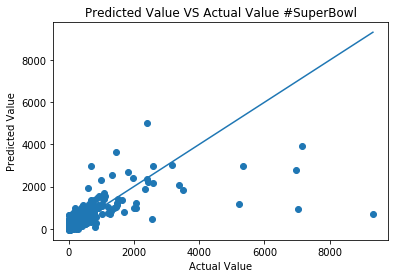

                            OLS Regression Results                            
Dep. Variable:                  tweet   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.392
Method:                 Least Squares   F-statistic:                     11.45
Date:                Sun, 22 Mar 2020   Prob (F-statistic):           1.74e-35
Time:                        14:26:47   Log-Likelihood:                -3499.9
No. Observations:                 439   AIC:                             7056.
Df Residuals:                     411   BIC:                             7170.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
tweet            0.3555      0.126      2.822   

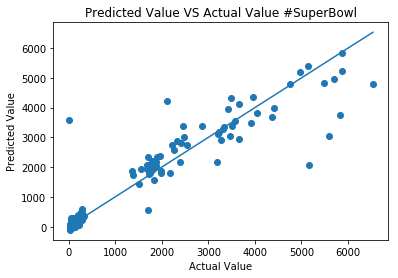

                            OLS Regression Results                            
Dep. Variable:                  tweet   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     31.43
Date:                Sun, 22 Mar 2020   Prob (F-statistic):           3.97e-41
Time:                        14:26:47   Log-Likelihood:                -1127.0
No. Observations:                 144   AIC:                             2308.
Df Residuals:                     117   BIC:                             2388.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
tweet            0.5588      0.183      3.054   

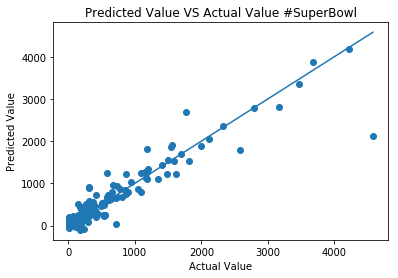

                            OLS Regression Results                            
Dep. Variable:                  tweet   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     26.07
Date:                Sun, 22 Mar 2020   Prob (F-statistic):           2.58e-35
Time:                        14:26:48   Log-Likelihood:                -956.73
No. Observations:                 134   AIC:                             1969.
Df Residuals:                     106   BIC:                             2051.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
tweet            0.9219      0.112      8.224   

array([2686.48598992, 1789.55527874, 1868.84180001, 1248.51699246,
        806.51777306,  831.06278813,  802.60304468, 1103.96580835,
       1214.47077086, 1704.82643925, 1549.17269934, 1436.41516768,
       1531.45363559, 1540.30936397, 2116.21373324, 4196.5047308 ,
       3885.5642041 , 3350.44066919, 2800.26887306, 2775.71381382,
       2369.18470714, 2050.7830292 , 1876.62220547, 1920.64678911,
       1271.50934807, 1213.87610856,  671.18114031,  671.14880915,
        927.01632422,  956.94408082,  660.76884263,   46.31687615,
        753.70487349,  857.91662103, 1137.46915879, 1095.31791526,
       1229.4257155 , 1338.57502441, 1804.35057315, 1274.22664272,
       1036.23074105,  865.93911943,  785.33881373,  603.50398054,
        632.22561993,  720.63553687,  390.6154442 ,  244.92542595,
        243.13309834,  526.19200014,  331.95356892,  224.94574061,
        220.49902077,  228.98738733,  521.60537508,  478.80043483,
        434.32610752,  471.42153199,  582.25641923,  681.25281

In [45]:
linear_regression(df_SuperBowl_piece1,'#SuperBowl')
linear_regression_minute(df_SuperBowl_piece2,'#SuperBowl')
linear_regression(df_SuperBowl_piece3,'#SuperBowl')

#### (vi) SB49

In [46]:
month_of_tweet, day_of_tweet, hour_of_tweet, min_of_tweet, number_of_followers, number_of_retweets, number_of_users=get_data_piece('#SB49')
df_SB49_piece2=process_data_piece(month_of_tweet, day_of_tweet, hour_of_tweet, min_of_tweet, number_of_followers, number_of_retweets, number_of_users)
df_SB49_piece1,df_SB49_piece3=cut_piece(df_sb49)

RMSE is: 79.824298866149


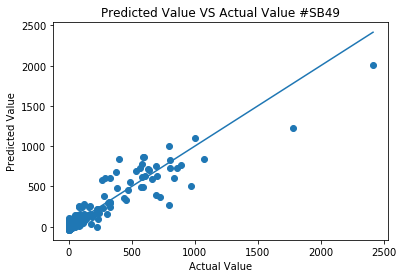

                            OLS Regression Results                            
Dep. Variable:                  tweet   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     108.4
Date:                Sun, 22 Mar 2020   Prob (F-statistic):          1.55e-168
Time:                        14:28:35   Log-Likelihood:                -2545.7
No. Observations:                 439   AIC:                             5147.
Df Residuals:                     411   BIC:                             5262.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
tweet            1.0446      0.040     25.862   

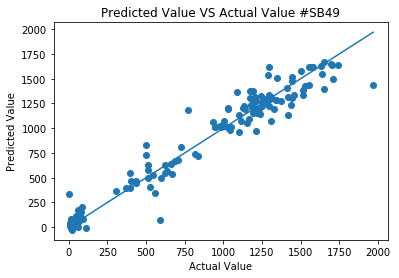

                            OLS Regression Results                            
Dep. Variable:                  tweet   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     82.14
Date:                Sun, 22 Mar 2020   Prob (F-statistic):           4.48e-63
Time:                        14:28:35   Log-Likelihood:                -903.54
No. Observations:                 144   AIC:                             1861.
Df Residuals:                     117   BIC:                             1941.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
tweet            0.6364      0.094      6.747   

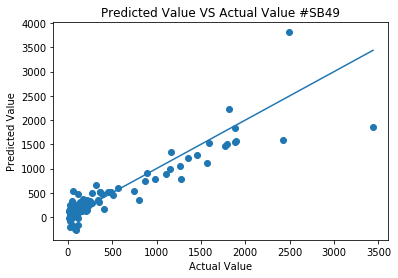

                            OLS Regression Results                            
Dep. Variable:                  tweet   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     19.23
Date:                Sun, 22 Mar 2020   Prob (F-statistic):           1.33e-29
Time:                        14:28:35   Log-Likelihood:                -929.65
No. Observations:                 134   AIC:                             1915.
Df Residuals:                     106   BIC:                             1996.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
tweet            0.7893      0.102      7.774   

array([ 3.81196920e+03,  1.86362776e+03,  2.22642197e+03,  1.34664957e+03,
        9.08232150e+02,  7.35773715e+02,  7.93266177e+02,  1.12492103e+03,
        1.51287679e+03,  1.56559382e+03,  1.54165094e+03,  1.46824368e+03,
        1.58857672e+03,  1.83770225e+03,  1.53721177e+03,  1.28870774e+03,
        1.21656732e+03,  1.05460559e+03,  9.86049298e+02,  8.96178523e+02,
        7.84959472e+02,  3.51469609e+02,  5.46864726e+02,  5.98121450e+02,
        1.60655376e+02,  6.68436368e+02,  1.25003032e+02,  2.40742917e+02,
        7.17145131e+01,  8.85682433e+01,  1.38274905e+02,  2.22436226e+02,
        2.75788818e+02,  3.16160371e+02,  5.24144196e+02,  5.24153777e+02,
        4.62493208e+02,  5.23158394e+02,  5.15734553e+02,  3.44075103e+02,
        4.70291396e+02,  4.90928856e+02,  3.37783571e+02,  2.34360191e+02,
        2.95961845e+02,  2.83565896e+02,  1.19806533e+02,  1.29215108e+02,
       -1.67226968e+02,  5.32332410e+02, -1.67433920e+02, -2.77414330e+01,
        2.11893545e+02,  

In [47]:
linear_regression(df_SB49_piece1,'#SB49')
linear_regression_minute(df_SB49_piece2,'#SB49')
linear_regression(df_SB49_piece3,'#SB49')

### Aggregate Data

### 7.

Also, aggregate the data of all hashtags, and train 3 models (for the intervals mentioned above) to predict the number of tweets in the next time window on the aggregated data.
Perform the same evaluations on your combined model and compare with models you trained for individual hashtags.

In [48]:
df_Aggregate=df_sb49
for i in range(len(df_sb49.month)):
    df_Aggregate.tweet[i] = df_Aggregate.tweet[i]+df_NFL.tweet[i]+df_GoPatriots.tweet[i]+df_GoHawks.tweet[i]+df_Patriots.tweet[i]+df_Superbowl.tweet[i]
    df_Aggregate.retweet[i] = df_Aggregate.retweet[i]+df_NFL.retweet[i]+df_GoPatriots.retweet[i]+df_GoHawks.retweet[i]+df_Patriots.retweet[i]+df_Superbowl.retweet[i]
    df_Aggregate.Maxfollowers[i] = df_Aggregate.Maxfollowers[i]+df_NFL.Maxfollowers[i]+df_GoPatriots.Maxfollowers[i]+df_GoHawks.Maxfollowers[i]+df_Patriots.Maxfollowers[i]+df_Superbowl.Maxfollowers[i]
    df_Aggregate.follower[i] = df_Aggregate.follower[i]+df_NFL.follower[i]+df_GoPatriots.follower[i]+df_GoHawks.follower[i]+df_Patriots.follower[i]+df_Superbowl.follower[i]
df_Aggregate

,month,day,hour,tweet,follower,retweet,Maxfollowers
0,1,14,0,111,223405,714,66893
1,1,14,1,89,187317,663,52935
2,1,14,2,110,1657090,640,1425702
3,1,14,3,100,165256,267,45226
4,1,14,4,137,444858,468,100462
...,...,...,...,...,...,...,...
582,2,7,6,36,220361,79,127995
583,2,7,7,85,1357094,242,167367
584,2,7,8,59,1489676,470,1277210
585,2,7,9,49,547334,102,230057


In [49]:
df_Aggregate_piece1,df_Aggregate_piece3=cut_piece(df_Aggregate)

In [50]:
df_Aggregate_piece2=df_SB49_piece2
for i in range(len(df_SB49_piece2.month)):
    df_Aggregate_piece2.tweet[i] = df_Aggregate_piece2.tweet[i]+df_NFL_piece2.tweet[i]+df_GoPatriots_piece2.tweet[i]+df_GoHawks_piece2.tweet[i]+df_Patriots_piece2.tweet[i]+df_SuperBowl_piece2.tweet[i]
    df_Aggregate_piece2.retweet[i] = df_Aggregate_piece2.retweet[i]+df_NFL_piece2.retweet[i]+df_GoPatriots_piece2.retweet[i]+df_GoHawks_piece2.retweet[i]+df_Patriots_piece2.retweet[i]+df_SuperBowl_piece2.retweet[i]
    df_Aggregate_piece2.Maxfollowers[i] = df_Aggregate_piece2.Maxfollowers[i]+df_NFL_piece2.Maxfollowers[i]+df_GoPatriots_piece2.Maxfollowers[i]+df_GoHawks_piece2.Maxfollowers[i]+df_Patriots_piece2.Maxfollowers[i]+df_SuperBowl_piece2.Maxfollowers[i]
    df_Aggregate_piece2.follower[i] = df_Aggregate_piece2.follower[i]+df_NFL_piece2.follower[i]+df_GoPatriots_piece2.follower[i]+df_GoHawks_piece2.follower[i]+df_Patriots_piece2.follower[i]+df_SuperBowl_piece2.follower[i]

RMSE is: 2043.0891277765588


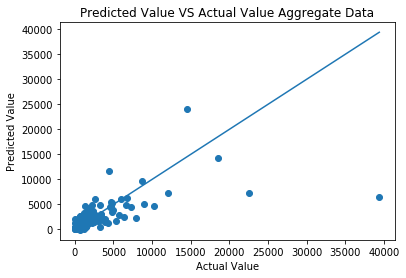

                            OLS Regression Results                            
Dep. Variable:                  tweet   R-squared:                       0.443
Model:                            OLS   Adj. R-squared:                  0.407
Method:                 Least Squares   F-statistic:                     12.12
Date:                Sun, 22 Mar 2020   Prob (F-statistic):           1.55e-37
Time:                        14:28:36   Log-Likelihood:                -3969.1
No. Observations:                 439   AIC:                             7994.
Df Residuals:                     411   BIC:                             8109.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
tweet            0.5751      0.145      3.972   

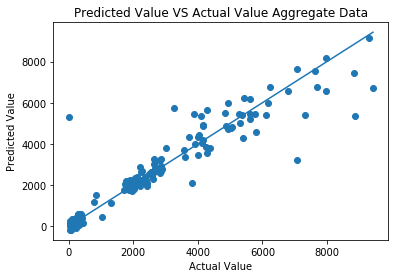

                            OLS Regression Results                            
Dep. Variable:                  tweet   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     29.55
Date:                Sun, 22 Mar 2020   Prob (F-statistic):           8.37e-40
Time:                        14:28:36   Log-Likelihood:                -1174.4
No. Observations:                 144   AIC:                             2403.
Df Residuals:                     117   BIC:                             2483.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
tweet            0.5014      0.178      2.820   

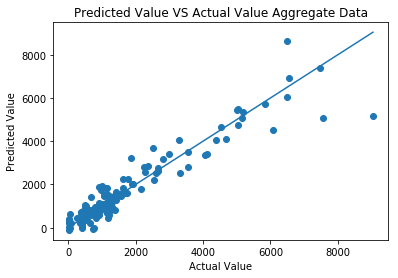

                            OLS Regression Results                            
Dep. Variable:                  tweet   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     30.76
Date:                Sun, 22 Mar 2020   Prob (F-statistic):           1.48e-38
Time:                        14:28:36   Log-Likelihood:                -1048.1
No. Observations:                 134   AIC:                             2152.
Df Residuals:                     106   BIC:                             2233.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
tweet            0.7614      0.121      6.290   

array([ 8.62286520e+03,  5.14965688e+03,  5.44028546e+03,  4.07247836e+03,
        2.52194169e+03,  2.19809257e+03,  2.53156401e+03,  3.38152437e+03,
        4.12037279e+03,  5.48266147e+03,  4.74125163e+03,  4.66078752e+03,
        4.50064615e+03,  5.08823139e+03,  5.08751350e+03,  7.40060363e+03,
        6.91718774e+03,  6.06293106e+03,  5.70451634e+03,  5.37160735e+03,
        4.04289834e+03,  3.41618353e+03,  3.51124201e+03,  3.40373107e+03,
        2.57554788e+03,  3.20405987e+03,  1.33791964e+03,  1.47432444e+03,
        1.48604693e+03,  1.57296074e+03,  1.30030926e+03,  8.34948245e+02,
        1.60516180e+03,  1.77178704e+03,  2.85698767e+03,  2.64233801e+03,
        2.79007491e+03,  3.15615196e+03,  3.68719725e+03,  2.74338093e+03,
        2.78613823e+03,  2.26006954e+03,  2.01433380e+03,  1.58789733e+03,
        1.82453720e+03,  1.81441913e+03,  7.84654403e+02,  8.01203095e+02,
        4.58673356e+02,  1.76616342e+03,  3.61789917e+02,  2.17434041e+02,
        7.95578898e+02,  

In [51]:
linear_regression(df_Aggregate_piece1,'Aggregate Data')
linear_regression_minute(df_Aggregate_piece2,'Aggregate Data')
linear_regression(df_Aggregate_piece3,'Aggregate Data')

In [52]:
import pickle
with open('df_Aggregate', 'wb') as fp:
    pickle.dump(df_Aggregate, fp)
    
with open('df_Aggregate1', 'wb') as fp:
    pickle.dump(df_Aggregate_piece1, fp)

with open('df_Aggregate2', 'wb') as fp:
    pickle.dump(df_Aggregate_piece2, fp)

with open('df_Aggregate3', 'wb') as fp:
    pickle.dump(df_Aggregate_piece3, fp)

**Data Summary Individual Hashtag:** 
- df_NFL,
- df_GoHawks,
- df_GoPatriots,
- df_Patriots,
- df_Superbowl,
- df_sb49

**Piecewice Individual Hashtag:**
- df_NFL_piece1, df_NFL_piece2, df_NFL_piece3
- df_GoHawks_piece1, df_GoHawks_piece2, df_GoHawks_piece3
- df_GoPatriots_piece1, df_GoPatriots_piece2, df_GoPatriots_piece3
- df_Patriots_piece1, df_Patriots_piece2, df_Patriots_piece3
- df_SB49_piece1, df_SB49_piece2, df_SB49_piece3
- df_SuperBowl_piece1, df_SuperBowl_piece2, df_SuperBowl_piece3

**Aggregate Data:**
- df_Aggregate,
- df_Aggregate_piece1,
- df_Aggregate_piece2,
- df_Aggregate_piece3

### 1-5. Nonlinear Regression

#### i) Ensemble Methods

In [53]:
def Training_Target(data_frame):
    #need to one hot encode time of day
    training_data = one_hot(data_frame, ['hour'])
    training_data.drop('hour', 1, inplace=True)
    training_data.drop('day', 1, inplace=True)
    training_data.drop('month', 1, inplace=True)
    target_data = training_data.tweet[1:]
    target_data = target_data.reset_index(drop=True)
    # print(target_data)
    training_data=training_data.drop([len(training_data.tweet)-1])
    # print(training_data)
    return training_data,target_data

In [54]:
def Training_Target2(data_frame):
    #need to one hot encode time of day
    training_data = one_hot(data_frame, ['hour','minute'])
    training_data.drop('hour', 1, inplace=True)
    training_data.drop('day', 1, inplace=True)
    training_data.drop('month', 1, inplace=True)
    training_data.drop('minute', 1, inplace=True)
    target_data = training_data.tweet[1:]
    target_data=target_data.reset_index(drop=True)
    #print(target_data)
    training_data=training_data.drop([len(training_data.tweet)-1])
    #print(training_data)
    return training_data,target_data

In [55]:
Training_Aggregated, Target_Aggregated = Training_Target(df_Aggregate)
print(df_Aggregate)
print(Training_Aggregated)
print(Target_Aggregated) # tweet counts in the next time window from training

     month  day  hour  tweet  follower  retweet  Maxfollowers
0        1   14     0    111    223405      714         66893
1        1   14     1     89    187317      663         52935
2        1   14     2    110   1657090      640       1425702
3        1   14     3    100    165256      267         45226
4        1   14     4    137    444858      468        100462
..     ...  ...   ...    ...       ...      ...           ...
582      2    7     6     36    220361       79        127995
583      2    7     7     85   1357094      242        167367
584      2    7     8     59   1489676      470       1277210
585      2    7     9     49    547334      102        230057
586      2    7    10     52    677744       80        252592

[587 rows x 7 columns]
     tweet  follower  retweet  Maxfollowers  hour_0  hour_1  hour_2  hour_3  \
0      111    223405      714         66893       1       0       0       0   
1       89    187317      663         52935       0       1       0       

### 8.

Use grid search to find the best parameter set for RandomForestRegressor and GradientBoostingRegressor, respectively. Analyze the result of the grid search. Do the test errors from cross-validation look good? If not, please explain the reason.

In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
Training_Aggregate, Target_Aggregate = Training_Target(df_Aggregate)
grid_1 = {
            'max_depth': [10, 30, 50, 70, 100, 200, None],
            'max_features': ['auto', 'sqrt'],
            'min_samples_leaf': [1, 2,3, 4],
            'min_samples_split': [2, 5, 10],
            'n_estimators': [200, 400, 600, 800, 1000,
                            1200, 1400, 1600, 1800, 2000]
            }
RF = RandomForestRegressor()
grid_search = GridSearchCV(RF, grid_1, n_jobs=-1, cv = KFold(5, shuffle=True), scoring='neg_mean_squared_error')
grid_search.fit(Training_Aggregate,Target_Aggregate)

D:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='war...
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [10, 30, 50, 70, 100, 200, None],
                  

In [57]:
from sklearn.ensemble import GradientBoostingRegressor
GBR = GradientBoostingRegressor()
grid_search2 = GridSearchCV(GBR, grid_1,n_jobs=-1,cv = KFold(5, shuffle=True), scoring='neg_mean_squared_error')
grid_search2.fit(Training_Aggregate,Target_Aggregate)

D:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_w...
                                                 verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,

In [58]:
print('The best Random Forest Regressor for Aggregate Data is')
print(grid_search.best_estimator_)
a = np.sqrt(grid_search.best_score_*-1)
print('The RMSE for this Estimator is',a)

The best Random Forest Regressor for Aggregate Data is
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=70,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
The RMSE for this Estimator is 15751.87589168475


In [59]:
print('The best Gradient Boosting Regressor for Aggregate Data is')
print(grid_search2.best_estimator_)
b = np.sqrt(grid_search2.best_score_*-1)
print('The RMSE for this Estimator is',b)

The best Gradient Boosting Regressor for Aggregate Data is
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=70,
                          max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1200,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
The RMSE for this Estimator is 16719.528283058004


### 9.

Compare the best estimator you found in the grid search with OLS on the entire dataset.

RMSE is: 11398.27021655293


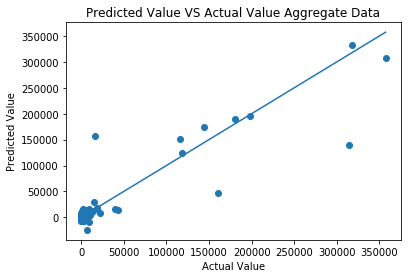

                            OLS Regression Results                            
Dep. Variable:                  tweet   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     105.9
Date:                Sun, 22 Mar 2020   Prob (F-statistic):          7.54e-200
Time:                        15:26:52   Log-Likelihood:                -6305.5
No. Observations:                 586   AIC:                         1.267e+04
Df Residuals:                     558   BIC:                         1.279e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
tweet            1.6281      0.064     25.508   

array([ 2.22361684e+01, -1.11787433e+02, -3.26176363e+01,  5.98626160e+02,
        1.91652190e+02,  6.22712865e+02,  4.43715926e+02,  1.45706488e+02,
       -3.12068169e+02,  1.21776212e+03,  5.92403301e+03, -1.11340250e+03,
       -1.70442538e+03,  1.34471228e+02,  8.72595719e+03, -1.05717467e+03,
        2.31545193e+03,  1.69134935e+03, -6.61147896e+02, -6.43545709e+03,
        1.54471137e+03,  1.10120555e+03, -1.27681433e+03,  3.49151720e+01,
        3.03896406e+02,  3.53795210e+02,  2.48819767e+02,  7.56075449e+02,
        5.28457787e+02,  6.15904098e+02,  6.14153312e+02,  5.05247912e+02,
        6.22730485e+02,  1.81292669e+03,  5.51785877e+03, -5.81324435e+02,
       -1.46142695e+03,  1.24352167e+02,  9.31607351e+03, -7.54648224e+02,
        2.35549359e+03,  1.66480451e+03, -8.52643647e+02, -6.51486766e+03,
        1.53432489e+03,  1.00864152e+03,  6.14042244e+02, -1.76310684e+01,
        3.35736602e+02,  9.18799057e+01,  9.39663322e+01,  5.98425455e+02,
        3.64308734e+02,  

In [60]:
linear_regression(df_Aggregate,'Aggregate Data')

### 10.  

For each time period described in 6., perform the same grid search above for GradientBoostingRegressor (with corresponding time window length). Does the cross validation test error change? Are the best parameter set you find in each period agree with those you found above?

In [61]:
Training_Aggregate1,Target_Aggregate1=Training_Target(df_Aggregate_piece1)
grid_search3 = GridSearchCV(GBR, grid_1,n_jobs=-1,cv = KFold(5, shuffle=True), scoring='neg_mean_squared_error')
grid_search3.fit(Training_Aggregate1,Target_Aggregate1)

D:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_w...
                                                 verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,

In [62]:
print('The best Gradient Boosting Regressor for Aggregate Data Piece 1 is')
print(grid_search3.best_estimator_)
c=np.sqrt(grid_search3.best_score_*-1)
print('The RMSE for this Estimator is',c)

The best Gradient Boosting Regressor for Aggregate Data Piece 1 is
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=200,
                          max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=10,
                          min_weight_fraction_leaf=0.0, n_estimators=2000,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
The RMSE for this Estimator is 2141.2479544016196


In [63]:
Training_Aggregate2,Target_Aggregate2=Training_Target2(df_Aggregate_piece2)
grid_search4 = GridSearchCV(GBR, grid_1,n_jobs=-1,cv = KFold(5, shuffle=True), scoring='neg_mean_squared_error')
grid_search4.fit(Training_Aggregate2,Target_Aggregate2)

D:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_w...
                                                 verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,

In [64]:
print('The best Gradient Boosting Regressor for Aggregate Data Piece 2 is')
print(grid_search4.best_estimator_)
d=np.sqrt(grid_search4.best_score_*-1)
print('The RMSE for this Estimator is',d)

The best Gradient Boosting Regressor for Aggregate Data Piece 2 is
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=100,
                          max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=2, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
The RMSE for this Estimator is 1014.152712497833


In [65]:
Training_Aggregate3,Target_Aggregate3=Training_Target(df_Aggregate_piece3)
grid_search5 = GridSearchCV(GBR, grid_1,n_jobs=-1,cv = KFold(5, shuffle=True), scoring='neg_mean_squared_error')
grid_search5.fit(Training_Aggregate3,Target_Aggregate3)

D:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_w...
                                                 verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,

In [66]:
print('The best Gradient Boosting Regressor for Aggregate Data Piece 3 is')
print(grid_search5.best_estimator_)
e=np.sqrt(grid_search5.best_score_*-1)
print('The RMSE for this Estimator is',e)

The best Gradient Boosting Regressor for Aggregate Data Piece 3 is
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=70,
                          max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=5,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
The RMSE for this Estimator is 644.4819044650641


#### ii) Neural Networks

### 11. 

Now try to regress the aggregated data with MLPRegressor. Try different architectures (i.e. the structure of the network) by adjusting hidden layer sizes. You should try at least 5 architectures with various numbers of layers and layer sizes. Report the architectures you tried, as well as its MSE of fitting the entire aggregated data.

In [68]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPRegressor

Training_Aggregate, Target_Aggregate = Training_Target(df_Aggregate)
grid_NN = {'hidden_layer_sizes':[(200,200,), (300,300,300,), (400,400,400,400,),
                               (500,500,500,500,500,),(800,800,800,800,800,800,800,800,),
                                 (100, 200, 300, 400, 500, 600, 700, 800, 700, 600, 500, 400, 300, 200, 100,)]
          }
NN = MLPRegressor(max_iter = 10000)
grid_search_NN = GridSearchCV(NN, grid_NN, n_jobs = 1, cv = KFold(n_splits=5,shuffle=True),scoring='neg_mean_squared_error', return_train_score = True, verbose = 2)
grid_search_NN.fit(Training_Aggregate,Target_Aggregate)

print("Best estimator for Neural Network : \n", grid_search_NN.best_estimator_)
print("Best score for Neural Network : ", -1*grid_search_NN.best_score_)
print("Best parameters for Neural Network : ", grid_search_NN.best_params_)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] hidden_layer_sizes=(200, 200) ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................... hidden_layer_sizes=(200, 200), total=   0.4s
[CV] hidden_layer_sizes=(200, 200) ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .................... hidden_layer_sizes=(200, 200), total=   0.4s
[CV] hidden_layer_sizes=(200, 200) ...................................
[CV] .................... hidden_layer_sizes=(200, 200), total=   0.2s
[CV] hidden_layer_sizes=(200, 200) ...................................
[CV] .................... hidden_layer_sizes=(200, 200), total=   0.3s
[CV] hidden_layer_sizes=(200, 200) ...................................
[CV] .................... hidden_layer_sizes=(200, 200), total=   0.3s
[CV] hidden_layer_sizes=(300, 300, 300) ..............................
[CV] ............... hidden_layer_sizes=(300, 300, 300), total=   1.3s
[CV] hidden_layer_sizes=(300, 300, 300) ..............................
[CV] ............... hidden_layer_sizes=(300, 300, 300), total=   1.6s
[CV] hidden_layer_sizes=(300, 300, 300) ..............................
[CV] ............... hidden_layer_sizes=(300, 300, 300), total=   1.1s
[CV] hidden_layer_sizes=(300, 300, 300) ..............................
[CV] .

D:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:568: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


[CV]  hidden_layer_sizes=(800, 800, 800, 800, 800, 800, 800, 800), total=   6.9s
[CV] hidden_layer_sizes=(800, 800, 800, 800, 800, 800, 800, 800) .....
[CV]  hidden_layer_sizes=(800, 800, 800, 800, 800, 800, 800, 800), total=  28.9s
[CV] hidden_layer_sizes=(800, 800, 800, 800, 800, 800, 800, 800) .....


D:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:568: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


[CV]  hidden_layer_sizes=(800, 800, 800, 800, 800, 800, 800, 800), total=  10.7s
[CV] hidden_layer_sizes=(800, 800, 800, 800, 800, 800, 800, 800) .....
[CV]  hidden_layer_sizes=(800, 800, 800, 800, 800, 800, 800, 800), total=  34.3s
[CV] hidden_layer_sizes=(800, 800, 800, 800, 800, 800, 800, 800) .....
[CV]  hidden_layer_sizes=(800, 800, 800, 800, 800, 800, 800, 800), total=  34.4s
[CV] hidden_layer_sizes=(100, 200, 300, 400, 500, 600, 700, 800, 700, 600, 500, 400, 300, 200, 100) 
[CV]  hidden_layer_sizes=(100, 200, 300, 400, 500, 600, 700, 800, 700, 600, 500, 400, 300, 200, 100), total=  16.2s
[CV] hidden_layer_sizes=(100, 200, 300, 400, 500, 600, 700, 800, 700, 600, 500, 400, 300, 200, 100) 
[CV]  hidden_layer_sizes=(100, 200, 300, 400, 500, 600, 700, 800, 700, 600, 500, 400, 300, 200, 100), total=  16.3s
[CV] hidden_layer_sizes=(100, 200, 300, 400, 500, 600, 700, 800, 700, 600, 500, 400, 300, 200, 100) 
[CV]  hidden_layer_sizes=(100, 200, 300, 400, 500, 600, 700, 800, 700, 600, 500,

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  4.6min finished
D:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best estimator for Neural Network : 
 MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100, 200, 300, 400, 500, 600, 700, 800, 700,
                                 600, 500, 400, 300, 200, 100),
             learning_rate='constant', learning_rate_init=0.001, max_iter=10000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)
Best score for Neural Network :  522467217.406664
Best parameters for Neural Network :  {'hidden_layer_sizes': (100, 200, 300, 400, 500, 600, 700, 800, 700, 600, 500, 400, 300, 200, 100)}


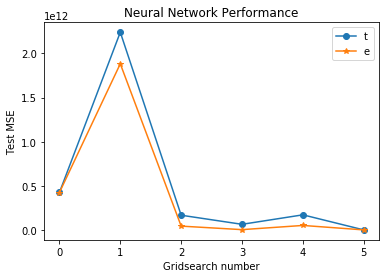

In [69]:
import matplotlib.lines as mlines

plt.figure()
plt.plot(-1*grid_search_NN.cv_results_['mean_train_score'], marker = 'o')
plt.xlabel("Gridsearch number")
plt.ylabel('Train MSE')


plt.plot(-1*grid_search_NN.cv_results_['mean_test_score'], marker = '*')
plt.legend('testing')
plt.xlabel("Gridsearch number") 
plt.ylabel('Test MSE')

plt.title('Neural Network Performance')
plt.show()

### 12.

Use StandardScaler to scale the features before feeding it to MLPRegressor (with the best architecture you got above). Does its performance increase?

In [70]:
from sklearn.preprocessing import StandardScaler 
X = Training_Aggregate.values
y = Target_Aggregate 

X_scaled = StandardScaler().fit_transform(X)
nn = MLPRegressor(hidden_layer_sizes=(100, 200, 300, 400, 500, 600, 700, 800, 700, 600, 500, 400, 300, 200, 100,))
nn.fit(X_scaled, y)
print("Training MSE using StandardScaler:", nn.loss_)

Training MSE using StandardScaler: 2298577.66609028


### 13. 

Using grid search, and the best architecture (for scaled data) for each period (with corresponding window length) described in **6**.

In [71]:
Training_Aggregate1,Target_Aggregate1=Training_Target(df_Aggregate_piece1)
Training_Aggregate1_scaled = StandardScaler().fit_transform(Training_Aggregate1)

grid_search_NN_1 = GridSearchCV(NN, grid_NN, n_jobs = 1, cv = KFold(n_splits=5,shuffle=True),scoring='neg_mean_squared_error', verbose = 2)
grid_search_NN_1.fit(Training_Aggregate1_scaled,Target_Aggregate1)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] hidden_layer_sizes=(200, 200) ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................... hidden_layer_sizes=(200, 200), total=  10.6s
[CV] hidden_layer_sizes=(200, 200) ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.5s remaining:    0.0s


[CV] .................... hidden_layer_sizes=(200, 200), total=   6.9s
[CV] hidden_layer_sizes=(200, 200) ...................................
[CV] .................... hidden_layer_sizes=(200, 200), total=   8.1s
[CV] hidden_layer_sizes=(200, 200) ...................................
[CV] .................... hidden_layer_sizes=(200, 200), total=   8.7s
[CV] hidden_layer_sizes=(200, 200) ...................................
[CV] .................... hidden_layer_sizes=(200, 200), total=  14.6s
[CV] hidden_layer_sizes=(300, 300, 300) ..............................
[CV] ............... hidden_layer_sizes=(300, 300, 300), total=   8.9s
[CV] hidden_layer_sizes=(300, 300, 300) ..............................
[CV] ............... hidden_layer_sizes=(300, 300, 300), total=  10.1s
[CV] hidden_layer_sizes=(300, 300, 300) ..............................
[CV] ............... hidden_layer_sizes=(300, 300, 300), total=   6.4s
[CV] hidden_layer_sizes=(300, 300, 300) ..............................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 15.0min finished
D:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             error_score='raise-deprecating',
             estimator=MLPRegressor(activation='relu', alpha=0.0001,
                                    batch_size='auto', beta_1=0.9, beta_2=0.999,
                                    early_stopping=False, epsilon=1e-08,
                                    hidden_layer_sizes=(100,),
                                    learning_rate='constant',
                                    learning_rate_init=0.001, max_iter=10000,
                                    momentum=0.9, n_iter_no_change=1...
                                    validation_fraction=0.1, verbose=False,
                                    warm_start=False),
             iid='warn', n_jobs=1,
             param_grid={'hidden_layer_sizes': [(200, 200), (300, 300, 300),
                                                (400, 400, 400, 400),
                                                (500, 500, 500, 500, 500),


In [74]:
print('The best MLPRegressor for Aggregate Data Piece 1 is')
print(grid_search_NN_1.best_estimator_)
mse_1 = grid_search_NN_1.best_score_*-1
print('The MSE for this Estimator is', mse_1)
rmse_1 = np.sqrt(grid_search_NN_1.best_score_*-1)
print('The RMSE for this Estimator is', rmse_1)

The best MLPRegressor for Aggregate Data Piece 1 is
MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100, 200, 300, 400, 500, 600, 700, 800, 700,
                                 600, 500, 400, 300, 200, 100),
             learning_rate='constant', learning_rate_init=0.001, max_iter=10000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)
The MSE for this Estimator is 5315716.9545163
The RMSE for this Estimator is 2305.5838641255928


In [75]:
Training_Aggregate2,Target_Aggregate2=Training_Target(df_Aggregate_piece2)
Training_Aggregate2_scaled = StandardScaler().fit_transform(Training_Aggregate2)

grid_search_NN_2 = GridSearchCV(NN, grid_NN, n_jobs = -1, cv = KFold(n_splits=5,shuffle=True),scoring='neg_mean_squared_error', verbose = 2)
grid_search_NN_2.fit(Training_Aggregate2_scaled,Target_Aggregate2)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:  4.8min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  5.5min finished
D:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             error_score='raise-deprecating',
             estimator=MLPRegressor(activation='relu', alpha=0.0001,
                                    batch_size='auto', beta_1=0.9, beta_2=0.999,
                                    early_stopping=False, epsilon=1e-08,
                                    hidden_layer_sizes=(100,),
                                    learning_rate='constant',
                                    learning_rate_init=0.001, max_iter=10000,
                                    momentum=0.9, n_iter_no_change=1...
                                    validation_fraction=0.1, verbose=False,
                                    warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(200, 200), (300, 300, 300),
                                                (400, 400, 400, 400),
                                                (500, 500, 500, 500, 500),

In [76]:
print('The best MLPRegressor for Aggregate Data Piece 2 is')
print(grid_search_NN_2.best_estimator_)
mse_2 = grid_search_NN_2.best_score_*-1
rmse_2 = np.sqrt(grid_search_NN_2.best_score_*-1)
print('The MSE for this Estimator is', mse_2)
print('The RMSE for this Estimator is', rmse_2)

The best MLPRegressor for Aggregate Data Piece 2 is
MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(800, 800, 800, 800, 800, 800, 800, 800),
             learning_rate='constant', learning_rate_init=0.001, max_iter=10000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)
The MSE for this Estimator is 1445256.2941616771
The RMSE for this Estimator is 1202.18812760802


In [77]:
Training_Aggregate3,Target_Aggregate3 = Training_Target(df_Aggregate_piece3)
Training_Aggregate3_scaled = StandardScaler().fit_transform(Training_Aggregate3)

grid_search_NN_3 = GridSearchCV(NN, grid_NN, n_jobs = 1, cv = KFold(n_splits=5,shuffle=True),scoring='neg_mean_squared_error', verbose = 2)
grid_search_NN_3.fit(Training_Aggregate3_scaled,Target_Aggregate3)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] hidden_layer_sizes=(200, 200) ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................... hidden_layer_sizes=(200, 200), total=  13.1s
[CV] hidden_layer_sizes=(200, 200) ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.0s remaining:    0.0s


[CV] .................... hidden_layer_sizes=(200, 200), total=  16.7s
[CV] hidden_layer_sizes=(200, 200) ...................................
[CV] .................... hidden_layer_sizes=(200, 200), total=  13.8s
[CV] hidden_layer_sizes=(200, 200) ...................................
[CV] .................... hidden_layer_sizes=(200, 200), total=   9.8s
[CV] hidden_layer_sizes=(200, 200) ...................................
[CV] .................... hidden_layer_sizes=(200, 200), total=  14.2s
[CV] hidden_layer_sizes=(300, 300, 300) ..............................
[CV] ............... hidden_layer_sizes=(300, 300, 300), total=  11.9s
[CV] hidden_layer_sizes=(300, 300, 300) ..............................
[CV] ............... hidden_layer_sizes=(300, 300, 300), total=  19.5s
[CV] hidden_layer_sizes=(300, 300, 300) ..............................
[CV] ............... hidden_layer_sizes=(300, 300, 300), total=  16.5s
[CV] hidden_layer_sizes=(300, 300, 300) ..............................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 18.4min finished
D:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             error_score='raise-deprecating',
             estimator=MLPRegressor(activation='relu', alpha=0.0001,
                                    batch_size='auto', beta_1=0.9, beta_2=0.999,
                                    early_stopping=False, epsilon=1e-08,
                                    hidden_layer_sizes=(100,),
                                    learning_rate='constant',
                                    learning_rate_init=0.001, max_iter=10000,
                                    momentum=0.9, n_iter_no_change=1...
                                    validation_fraction=0.1, verbose=False,
                                    warm_start=False),
             iid='warn', n_jobs=1,
             param_grid={'hidden_layer_sizes': [(200, 200), (300, 300, 300),
                                                (400, 400, 400, 400),
                                                (500, 500, 500, 500, 500),


In [78]:
print('The best MLPRegressor for Aggregate Data Piece 3 is')
print(grid_search_NN_3.best_estimator_)
mse_3 = grid_search_NN_3.best_score_*-1
print('The MSE for this Estimator is', mse_3)
rmse_3 = np.sqrt(grid_search_NN_3.best_score_*-1)
print('The RMSE for this Estimator is', rmse_3)

The best MLPRegressor for Aggregate Data Piece 3 is
MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(800, 800, 800, 800, 800, 800, 800, 800),
             learning_rate='constant', learning_rate_init=0.001, max_iter=10000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)
The MSE for this Estimator is 2672624.7881032173
The RMSE for this Estimator is 1634.8164386570186


#### 1-6. Using 6x window to predict

Download the test data. Each file in the test data contains a hashtag's tweets from a 6x- window-length time range. Fit a model on the aggregate of the training data for all hashtags, and predict the number of tweets in the next hour for each test file. The file names consist of sample number followed by the period number the data is from.

For example, a file named sample0 period1.txt contains tweets in a sample 6-hour4 window
that lies in the 1st time period described in Question 6, while a file named sample0 period2.txt contains tweets in a sample 30-min5 window that lies in the 2nd time period. One can be creative here, and use the data from all previous 6-hour windows for making more accurate predictions (as opposed to using features from the previous hour only).

### 14.

Report the model you use. For each test file, provide your predictions on the number of tweets in the next time window.
Note: Test data should not be used as a source for training. You are not bounded to only linear models. You can find your best model through cross-validation of your training data.


In [249]:
#First test the linear method by cross validation to prove that it yields better results than non-linear ones
from sklearn.model_selection import KFold

def linear_regression_cv(data_frame, hashtag, nFold, pp_method, runs):
    #need to one hot encode time of day usinf 1-hour time window
    X,y = pp_method(data_frame)
    #print(X)
    #print(y)
    #print(training_data)
    linear_reg = LinearRegression(fit_intercept = False)
    train_rmse = []
    test_rmse = []
    for i in range(runs):
        kf = KFold(n_splits=nFold, random_state=None, shuffle=True)
        for train_index, test_index in kf.split(X):
            #print(train_index, test_index)
            X_train, X_test = X.iloc(axis=0)[train_index], X.iloc(axis=0)[test_index]
            y_train, y_test = y.iloc(axis=0)[train_index], y.iloc(axis=0)[test_index]
            #training
            linear_regression_fitted = linear_reg.fit(X_train, y_train)
            predicted = linear_regression_fitted.predict(X_train)
            RMSE = calculate_RMSE(predicted, y_train)
            train_rmse.append(RMSE)
            #testing
            predicted = linear_regression_fitted.predict(X_test)
            RMSE = calculate_RMSE(predicted, y_test)
            test_rmse.append(RMSE)
    print('Average Training RMSE for '+ hashtag +' is:' + str(getListAverage(train_rmse)))
    print('Average Testing RMSE for '+ hashtag +' is:' + str(getListAverage(test_rmse)) + '\n')

In [250]:
#helper
def getListAverage(ls):
    if(len(ls) == 0): print("empty list input for getting average.")
    return sum(ls)/len(ls)

In [251]:
default_nfold = 5
num_run = 10 #since the slicing is random, run 10 times to get more representative result

linear_regression_cv(df_Aggregate, 'Aggregate Data', default_nfold, Training_Target, num_run)
linear_regression_cv(df_Aggregate_piece1, 'Aggregate Data 1', default_nfold, Training_Target,num_run)
linear_regression_cv(df_Aggregate_piece2, 'Aggregate Data 2', default_nfold, Training_Target2,num_run)
linear_regression_cv(df_Aggregate_piece3, 'Aggregate Data 3', default_nfold, Training_Target,num_run)

Average Training RMSE for Aggregate Data is:10997.814894527919
Average Testing RMSE for Aggregate Data is:12389.086476284852

Average Training RMSE for Aggregate Data 1 is:1965.1202241498363
Average Testing RMSE for Aggregate Data 1 is:2141.074908141381

Average Training RMSE for Aggregate Data 2 is:806.0793764659632
Average Testing RMSE for Aggregate Data 2 is:1080.3962223317537

Average Training RMSE for Aggregate Data 3 is:549.2345821337253
Average Testing RMSE for Aggregate Data 3 is:998.1103604990587



The simple linear regression method yields the optimal result for all aggregated data, except for period 2. Now we process testing data.
We approach the problem by using the same method as before, reading the data into 1hr/5min windows, then combine them into a single datapoint with 6x window length.

In [252]:
from sklearn.ensemble import GradientBoostingRegressor

agent1 = LinearRegression(fit_intercept = False) #for period 1, 3
agent2 = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls',
                          max_depth=100, max_features='sqrt',
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=1,
                          min_samples_split=2, min_weight_fraction_leaf=0.0,
                          n_estimators=800, n_iter_no_change=None, random_state=None,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)


In [253]:
#get all data files
from os import listdir

dir = './tweet_test'
files = listdir(dir)
print(files)

['sample0_period1.txt', 'sample0_period2.txt', 'sample0_period3.txt', 'sample1_period1.txt', 'sample1_period2.txt', 'sample1_period3.txt', 'sample2_period1.txt', 'sample2_period2.txt', 'sample2_period3.txt']


In [254]:
#modify get_data(); use filename directly for reading 
def get_datafile(dir, filename):   
    # number_of_tweets_per_hr = []
    number_of_followers = []
    number_of_retweets = []
    day_of_tweet = []
    hour_of_tweet = []
    month_of_tweet = []
    time_stamp = []
    #rank=[]
    pst_tz = pytz.timezone('America/Los_Angeles')
    file = open( dir + '/' + filename ,errors='ignore')
    # need to handle duplicates in users tweeting for actual number of users and for the number of followers
    authors = set()
    for line in file:
        data = json.loads(line)
        # look up the time a tweet is posted
        timestamp = (data['citation_date'])
        time_stamp.append(timestamp)
        # convert UIX time to human-readable date
        timedata = datetime.datetime.fromtimestamp(timestamp,pst_tz)
        #ranktmp=100*timedata.month+timedata.day+0.01*timedata.hour
        #rank.append(ranktmp)
        day_of_tweet.append(timedata.day)
        hour_of_tweet.append(timedata.hour)
        month_of_tweet.append(timedata.month)
        # assess the number of retweets of a tweet:
        number_of_retweets.append(data['metrics']['citations']['total'])
        if data['tweet']['user']['id'] not in authors:
            authors.add(data['tweet']['user']['id'])
        # number of followers of the person tweeting 
        number_of_followers.append(data['author']['followers'])
    file.close()
    number_of_users = len(authors)
    total_hours = float(max(time_stamp) - min(time_stamp))/3600.0
    return month_of_tweet, day_of_tweet, hour_of_tweet, number_of_followers, number_of_retweets, number_of_users

In [255]:
#modify process_data to return only df, which is no longer null-padded
def process_datafile(month,day,hour,followers,retweets,users):
    monthsum=[month[0]]
    daysum=[day[0]]
    hoursum=[hour[0]]
    followersum=[followers[0]]
    retweetsum=[retweets[0]]
    tweetsum=[1]
    maxfollowers=[followers[0]]
    for i in range(len(day)):
        if i != 0:
            for j in (range(len(daysum))):
                if (month[i] == monthsum[j]) and (day[i] == daysum[j]) and (hour[i] == hoursum[j]):
                    followersum[j]=followersum[j]+followers[i]
                    retweetsum[j]=retweetsum[j]+retweets[i]
                    tweetsum[j]=tweetsum[j]+1
                    if followers[i] > maxfollowers[j]:
                        maxfollowers[j]=followers[i]
                    break
                else:
                    if j == len(daysum)-1:
                        monthsum.append(month[i])
                        daysum.append(day[i])
                        hoursum.append(hour[i])
                        followersum.append(followers[i])
                        retweetsum.append(retweets[i])
                        tweetsum.append(1)
                        maxfollowers.append(followers[i])
    data={'month':monthsum,'day':daysum,'hour':hoursum,'follower':followersum,'retweet':retweetsum,'tweet':tweetsum,'Maxfollowers':maxfollowers}
    df = DataFrame(data)
    df=df.sort_values(by=['month','day','hour'])
    df=df.reset_index(drop=True)
    return df

In [262]:
#read all data with 1hr window.
test_df_hr = []

hr_files = ['sample0_period1.txt', 'sample0_period3.txt', 'sample1_period1.txt', 'sample1_period3.txt', 'sample2_period1.txt', 'sample2_period3.txt']
for file in hr_files:
    M,D,H,F,R,U=get_datafile(dir, file)
    df = process_datafile(M,D,H,F,R,U)
    print(df)
    test_df_hr.append(df)

   month  day  hour   follower  retweet  tweet  Maxfollowers
0      1   31     5   424498.0      109     52      168371.0
1      1   31     6  2975692.0      761     79     2034387.0
2      1   31     7   860594.0      226     94      328882.0
3      1   31     8  2349147.0      258    101      368626.0
4      1   31     9  1369748.0      483    122      291130.0
5      1   31    10  9022480.0      322    120     5883161.0
   month  day  hour   follower  retweet  tweet  Maxfollowers
0      2    4     0  3564378.0       74     59     3329958.0
1      2    4     1   146905.0      103     48       59219.0
2      2    4     2    99613.0       99     94       16753.0
3      2    4     3   119754.0       61     45       27669.0
4      2    4     4   505238.0      141     77      257549.0
5      2    4     5   164136.0      131     87       27199.0
   month  day  hour   follower  retweet  tweet  Maxfollowers
0      2    1     1   509311.0      526    203      104627.0
1      2    1     2  167

In [256]:
#modify get_data_piece and process_data_piece
def get_datafile_piece(dir, filename):   
    number_of_followers = []
    number_of_retweets = []
    day_of_tweet = []
    hour_of_tweet = []
    month_of_tweet = []
    time_stamp = []
    min_of_tweet = []
    #rank=[]
    pst_tz = pytz.timezone('America/Los_Angeles')
    file = open(dir + '/' + filename, errors='ignore')
    # need to handle duplicates in users tweeting for actual number of users and for the number of followers
    authors = set()
    for line in file:
        data = json.loads(line)
        timestamp=(data['citation_date'])
        timedata= datetime.datetime.fromtimestamp(timestamp,pst_tz)
        #ranktmp=100*timedata.month+timedata.day+0.01*timedata.hour
        #rank.append(ranktmp)
        if (timedata.day == 1 and timedata.hour >=8 and timedata.hour <20):
            day_of_tweet.append(timedata.day)
            hour_of_tweet.append(timedata.hour)
            month_of_tweet.append(timedata.month)
            min_of_tweet.append(timedata.minute)
            number_of_retweets.append(data['metrics']['citations']['total'])
            if data['tweet']['user']['id'] not in authors:
                authors.add(data['tweet']['user']['id'])
            number_of_followers.append(data['author']['followers'])
    file.close()
    number_of_users = len(authors)
    return month_of_tweet, day_of_tweet, hour_of_tweet, min_of_tweet, number_of_followers, number_of_retweets, number_of_users

def process_datafile_piece(month,day,hour,minute,followers,retweets,users):
    monthsum=[month[0]]
    daysum=[day[0]]
    hoursum=[hour[0]]
    minsum=[minute[0]]
    followersum=[followers[0]]
    retweetsum=[retweets[0]]
    tweetsum=[1]
    maxfollowers=[followers[0]]
    for i in range(len(day)):
        if i != 0:
                for j in (range(len(daysum))):
                    if (month[i] == monthsum[j]) and (day[i] == daysum[j]) and (hour[i] == hoursum[j]) and (minute[i] == minsum[j]):
                        followersum[j]=followersum[j]+followers[i]
                        retweetsum[j]=retweetsum[j]+retweets[i]
                        tweetsum[j]=tweetsum[j]+1
                        if followers[i] > maxfollowers[j]:
                            maxfollowers[j]=followers[i]
                        break
                    else:
                        if j == len(daysum)-1:
                            monthsum.append(month[i])
                            minsum.append(minute[i])
                            daysum.append(day[i])
                            hoursum.append(hour[i])
                            followersum.append(followers[i])
                            retweetsum.append(retweets[i])
                            tweetsum.append(1)
                            maxfollowers.append(followers[i])
    data={'month':monthsum,'day':daysum,'hour':hoursum,'minute':minsum,'follower':followersum,'retweet':retweetsum,'tweet':tweetsum,'Maxfollowers':maxfollowers}
    df = DataFrame(data)
    df=df.sort_values(by=['month','day','hour','minute'])
    df=df.reset_index(drop=True)
    return df

In [263]:
#the hr data is already in 6x 1hr, now read and format min data into 6x 5min
import numpy as np

min_files = ['sample0_period2.txt', 'sample1_period2.txt', 'sample2_period2.txt']
test_df_min = []

for file in min_files:
    month_of_tweet, day_of_tweet, hour_of_tweet, min_of_tweet, number_of_followers, number_of_retweets, number_of_users = get_datafile_piece(dir, file)
    df = process_datafile_piece(month_of_tweet, day_of_tweet, hour_of_tweet, min_of_tweet, number_of_followers, number_of_retweets, number_of_users)
    i = 0
    while (i < 6): #specifed 6 window in total
        df.iloc[i,-1] = np.amax(df.iloc[i:i+5,-1])
        for j in range(1,5):#combine next 4 min
            for k in range(4,7):#repeat for the first 3 non-time features
                df.iloc[i, k] += df.iloc[i+j, k]
        #print(df.iloc(axis=0)[i])
        df.drop(df.index[[i+1,i+2,i+3,i+4]], inplace=True)
        i+=1
    print(df)
    test_df_min.append(df)

    month  day  hour  minute    follower  retweet  tweet  Maxfollowers
0       2    1    19       0  24203772.0     6513   3472     9184266.0
5       2    1    19       5  22725112.0     7379   3834     7302096.0
10      2    1    19      10  12291299.0     4403   2258     3798149.0
15      2    1    19      15   4922162.0     3371   1455      837831.0
20      2    1    19      20   4494678.0     2097   1235     1379807.0
25      2    1    19      25   3130226.0     2013   1123      364454.0
    month  day  hour  minute    follower  retweet  tweet  Maxfollowers
0       2    1    12      30   1140913.0     1393    960      232232.0
5       2    1    12      35   3134832.0     1567    995     1320786.0
10      2    1    12      40   1876968.0     1578    870      995797.0
15      2    1    12      45  10780788.0     1604    960     5044900.0
20      2    1    12      50    872789.0     1245    861      176067.0
25      2    1    12      55   3845014.0     1457    903     1301090.0
    mo

In [258]:
#make new features by all prev. 6 windows 
index_offset = 5 #only keep entries starting from the 6th one, i.e. the first one with previous 5 hours
def Training_Target_6x(data_frame):
    #need to one hot encode time of day
    training_data = one_hot(data_frame, ['hour'])
    training_data.drop('hour', 1, inplace=True)
    training_data.drop('day', 1, inplace=True)
    training_data.drop('month', 1, inplace=True)
    #modified applicable target data
    start = index_offset+1 #first predictable
    end = len(training_data.tweet)-index_offset-1 #last predictable
    target_data = training_data.tweet[start:]
    target_data = target_data.reset_index(drop=True)
    
    #now make new features by by concatenate previous 6 windows' feature (5 prev + 1 immediately before prediction)
    features = []
    for i in range(len(target_data)):
        feature = []
        for j in range(0,index_offset+1):
            for k in range(0,4):
                col = training_data.iloc[i+j, k]
                feature.append(col)
        features.append(feature)
    
    return pd.DataFrame(features),target_data

#get Training data for period 1 and 3
X1, y1 = Training_Target_6x(df_Aggregate_piece1)
X3, y3 = Training_Target_6x(df_Aggregate_piece3)
#print(X1, y1)

In [259]:
#now do the same for period 2
def Training_Target2_6x(data_frame):
    index_offset = 5
    #need to one hot encode time of day
    training_data = one_hot(data_frame, ['hour','minute'])
    training_data.drop('hour', 1, inplace=True)
    training_data.drop('day', 1, inplace=True)
    training_data.drop('month', 1, inplace=True)
    training_data.drop('minute', 1, inplace=True)
    
    start = index_offset+1 #first predictable
    end = len(training_data.tweet)-index_offset-1 #last predictable
    target_data = training_data.tweet[start:]
    target_data = target_data.reset_index(drop=True)
    
    features = []
    for i in range(len(target_data)):
        feature = []
        for j in range(0,index_offset+1):
            for k in range(0,4):
                col = training_data.iloc[i+j, k]
                feature.append(col)
        features.append(feature)
    
    return pd.DataFrame(features),target_data
#get Training data for period 1 and 3
X2, y2 = Training_Target2_6x(df_Aggregate_piece2)
#print(X2, y2)

Before we can train the agents on the prepared sets, test to make sure that combining all 6 previous windows improves the prediction and that the best methods remain the same for each period.

In [260]:
def regression_cv_6x(X, y, hashtag, nFold, runs, agent, agentname):
    train_rmse = []
    test_rmse = []
    for i in range(runs):
        kf = KFold(n_splits=nFold, random_state=None, shuffle=True)
        for train_index, test_index in kf.split(X):
            #print(train_index, test_index)
            X_train, X_test = X.iloc(axis=0)[train_index], X.iloc(axis=0)[test_index]
            y_train, y_test = y.iloc(axis=0)[train_index], y.iloc(axis=0)[test_index]
            #training
            regression_fitted = agent.fit(X_train, y_train)
            predicted = regression_fitted.predict(X_train)
            RMSE = calculate_RMSE(predicted, y_train)
            train_rmse.append(RMSE)
            #testing
            predicted = regression_fitted.predict(X_test)
            RMSE = calculate_RMSE(predicted, y_test)
            test_rmse.append(RMSE)
    print('Average Training RMSE for '+ hashtag +' with ' + agentname + ' is:' + str(getListAverage(train_rmse)))
    print('Average Testing RMSE for '+ hashtag +' with ' + agentname + ' is:' + str(getListAverage(test_rmse)) + '\n')

regression_cv_6x(X1,y1,'Period 1', 5, 10, agent1, 'linear')
regression_cv_6x(X2,y2,'Period 2', 5, 10, agent1, 'linear')
regression_cv_6x(X3,y3,'Period 3', 5, 10, agent1, 'linear')

regression_cv_6x(X2,y2,'Period 2', 5, 10, agent2, 'Best GBR')


Average Training RMSE for Period 1 with linear is:1674.1709782432733
Average Testing RMSE for Period 1 with linear is:2532.391299256521

Average Training RMSE for Period 2 with linear is:782.9397328252412
Average Testing RMSE for Period 2 with linear is:1929.2830181922461

Average Training RMSE for Period 3 with linear is:292.7868323524985
Average Testing RMSE for Period 3 with linear is:594.2041897607328

Average Training RMSE for Period 2 with Best GBR is:0.00031322681213152446
Average Testing RMSE for Period 2 with Best GBR is:1115.0960052720066



The previous test actually suggested that time data are better discarded because the concatenated feature including all the one-hot enconded time feature will result in very bad overfitting while not improving on the test RMSE metric much.
Ohter methods are easily tested by passing X_i, y_i as new input. The optimal methods remain the same.

In [264]:
#now we can finally predict on the test set by extracting new features from them
#recall we have test_df_hr and test_df_min

def test_predict_hr(test_set, agent, X, y):
    #get featured datapoint
    #print(test_set)
    feature = []
    for i in range(1):
        for j in range(0,index_offset+1):
            #match the data sequence of the training set
            tweet = test_set.iloc[i+j, 5]
            follower = test_set.iloc[i+j, 3]
            retweet = test_set.iloc[i+j, 4]
            maxfollow = test_set.iloc[i+j, 6]
            items = [tweet, follower, retweet, maxfollow]
            for item in items:
                feature.append(item)
    #print(len(feature))
    fitted = agent.fit(X,y)
    prediction = fitted.predict(pd.DataFrame([feature]))
    
    return prediction

def test_predict_min(test_set, agent, X, y):
    #get featured datapoint
    #print(test_set)
    feature = []
    for i in range(1):
        for j in range(0,index_offset+1):
            #match the data sequence of the training set
            tweet = test_set.iloc[i+j, 6]
            follower = test_set.iloc[i+j, 4]
            retweet = test_set.iloc[i+j, 5]
            maxfollow = test_set.iloc[i+j, 7]
            items = [tweet, follower, retweet, maxfollow]
            for item in items:
                feature.append(item)
    #print(len(feature))
    fitted = agent.fit(X,y)
    prediction = fitted.predict(pd.DataFrame([feature]))
    
    return prediction

data_hr = [(X1,y1), (X3, y3), (X1, y1), (X3, y3), (X1, y1), (X3, y3)]
for i in range(len(test_df_hr)) :
    print('For the test file: ' + hr_files[i])
    print('the predicted tweets for the next hour are: ' + str(test_predict_hr(test_df_hr[i], agent1, data_hr[i][0], data_hr[i][1])[0]) + '\n')

for i in range(len(test_df_min)) :
    print('For the test file: ' + min_files[i])
    print('the predicted tweets for the next 5 minutes are: ' + str(test_predict_min(test_df_min[i], agent2, X2, y2)[0]) + '\n')


For the test file: sample0_period1.txt
the predicted tweets for the next hour are: 127.42883940120839

For the test file: sample0_period3.txt
the predicted tweets for the next hour are: 124.84705528765721

For the test file: sample1_period1.txt
the predicted tweets for the next hour are: 787.7368102875156

For the test file: sample1_period3.txt
the predicted tweets for the next hour are: 173.37582544704387

For the test file: sample2_period1.txt
the predicted tweets for the next hour are: 57.31901706317703

For the test file: sample2_period3.txt
the predicted tweets for the next hour are: -15.827906607588769

For the test file: sample0_period2.txt
the predicted tweets for the next 5 minutes are: 2313.4498787740204

For the test file: sample1_period2.txt
the predicted tweets for the next 5 minutes are: 1569.3818560225118

For the test file: sample2_period2.txt
the predicted tweets for the next 5 minutes are: 231.47342507355248



## Part 2 -- Fan Base Prediction

The textual content of a tweet can reveal some information about the author. For instance,
users tweeting on a topic may have opposing views about it. In particular, tweets posted
by fans of different teams during a sport game describe similar events in different terms and
sentiments. Recognizing that supporting a sport team has a lot to do with the user location,
we try to use the textual content of the tweet posted by a user to predict their location. In
order to make the problem more specific, let us consider all the tweets including #superbowl,
posted by the users whose specified location is either in the state of Washington (not D.C.!)
or Massachusetts. For example, in order to include all the tweets with the author located in
the state of Washington, we consider the tweets that include the following substrings in the
location field (json_object['tweet']['user']['location'] ):
- Seattle, Washington
- Washington
- WA
- Seattle, WA
- Kirkland, Washington
- etc.


### 15.

1. Explain the method you use to determine whether the location is in Washington, Massachusetts or neither. Only use the tweets whose authors belong to either Washington or Massachusetts for the next part.

There are no exact coordinates data in the set, so we used regular expression to select users in these 2 states by their indicated general location.

In [1]:
import re

#parse the location, return 0 for washington state, 1 for mass. -1 for neither
def parse_locale(location):# the twitter metadata format for state abbr. is "AB"; for D.C. is not clear
    if ((re.match('.*Washington$', location) or re.match('.*, Washington.*', location) or re.match('.*WA$', location)) or re.match('.*, WA.*', location) and not re.match('.*DC.*', location) and not re.match('.*D\\.C\\..*', location)):
        return 0
    elif (re.match('.*Massachusetts$', location) or re.match('.*, Massachusetts.*', location) or re.match('.*MA$', location) or re.match('.*, MA.*', location)):
        return 1
    else:
        return -1

2. Train a binary classifier to predict the location of the author of a tweet (Washington or Massachusetts), given only the textual content of the tweet (using the techniques you learnt in project 1). Try different classification algorithms (at least 3). For each, plot ROC curve, report confusion matrix, and calculate accuracy, recall and precision.

In [3]:
import json
#We first format the data and parse locations
filepath = './tweet_data/tweets_#superbowl.txt'

#for this part, we only need the "title" for textual content and "location" for locations
texts = []
locales = []

fh = open(filepath, 'r')
for line in fh:
    data = json.loads(line)
    text = data['title']
    location = data['tweet']['user']['location']
    locale_tag = parse_locale(location)
    if (locale_tag != -1):
        locales.append(locale_tag)
        texts.append(text)
        
fh.close()
'''#for manual sanity checks
df = pd.DataFrame({
    'text' : texts,
    'locale_tag' : locales
}, columns = ['text', 'locale_tag'])

filepath = './Q15.csv'
fh=open(filepath, 'w')
df.to_csv('./Q15.csv', index = False)
'''
num_tweet = len(texts)
print(num_tweet)

24975


Now we can parse the textual data as we did in project 1 and 2

In [4]:
import nltk
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

lemmatizer = WordNetLemmatizer()

pp_texts = []
for text in texts:
    re.sub('http.*', '', text) #reduce bad features
    word_list = nltk.word_tokenize(text)
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    pp_texts.append(lemmatized_output)

count_vect = CountVectorizer(min_df=3, stop_words ='english')
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(count_vect.fit_transform(pp_texts))

print (X_tfidf.shape)

(24975, 5919)


[0.01001318 0.01299895 0.01140377 0.00827587 0.0069101  0.0068458
 0.00603221 0.00519349 0.00507108 0.00497607 0.00475984 0.00452572
 0.00436085 0.00413709 0.0039762  0.00393796 0.00390134 0.0037332
 0.00368564 0.00356733 0.00349681 0.00334722 0.0032785  0.00325652
 0.00317929 0.00310998 0.00309806 0.00303529 0.00298979 0.00292823]
0.8326689307269098
24975.0
Reduced SVD shape: (24975, 2000)


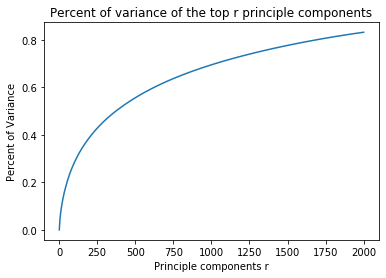

In [9]:
from sklearn.decomposition import TruncatedSVD
import numpy as np
import matplotlib.pyplot as plt

#baseline dimension reduction by svd
num_comp = 2000
svd = TruncatedSVD(n_components = num_comp, algorithm='randomized',n_iter=5, random_state=None,tol=0.0)
svd_reduced = svd.fit_transform(X_tfidf)
print(svd.explained_variance_ratio_[:30:1])
print(svd.explained_variance_ratio_.sum())
print(np.dot(X_tfidf.T, X_tfidf).diagonal().sum())
print('Reduced SVD shape:', svd_reduced.shape)

# Sort in ascending order
svd_ascend = np.sort(svd.explained_variance_ratio_)

# Reverse the sorted array
svd_descend = svd_ascend[::-1]

top_r = [0]*num_comp

for i in range(num_comp):
    top_r[i] = svd_descend[0:i].sum()

#plot of the percent of variance the top r principle components can retain v.s. r,
x = np.arange(1, num_comp+1)
fig, ax = plt.subplots() #returns a tuple containing a fig and axes object(s)
ax.plot(x, top_r)
ax.set(xlabel='Principle components r', ylabel='Percent of Variance',
      title='Percent of variance of the top r principle components')
fig.savefig("Percent of variance of the top r principle components.png")
plt.show()

# Turn on the minor TICKS
ax.minorticks_on()

#Customize the grids
ax.grid(which='major',linestyle='--', linewidth='0.5', color='red')
ax.grid(which='minor',linestyle=':', linewidth='0.5', color='black')

In [151]:
#metric helper functions
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

def get_metrics(true, predicted, verbose):
    accuracy = metrics.accuracy_score(true, predicted)
    precision = metrics.precision_score(true, predicted, average='macro')
    if(verbose):
        print("The accuracy is ", accuracy)
        print("The precision is ", precision)
        print("The recall is ", metrics.recall_score(true, predicted, average='macro'))
        print("The confusion matrix is ")
        print(metrics.confusion_matrix(true, predicted))
    return accuracy, precision

from sklearn.metrics import roc_curve, auc

# draw roc curve
def plot_roc_curve(agentname, fpr, tpr, auc):
    plt.figure(figsize=(15,9))
    plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.3f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC curve ('+ agentname +')', fontsize=23)
    plt.legend(loc="lower right")
    plt.show()

In [266]:
#now define a helper function to train all agents
from sklearn.model_selection import GridSearchCV, train_test_split, KFold

def classify(agent, agentname, param, clf_type, r=[10,15,20,30,50,100,200,400,600,800]):
    accuracy = []
    precision = []
    for val in r:
        print("Using LSI(" + str(val) + ' components) and ' + agentname + ': ')
        X_train, X_test, y_train, y_test = train_test_split(svd_reduced[:,:val], locales, test_size=0.1, random_state=42)
        best_agent = GridSearchCV(agent, param, cv=None)#KFold(5, shuffle=True))
        best_agent.fit(X_train,y_train)
        print(best_agent.best_params_)
        
        true, predicted = y_test, best_agent.predict(X_test)

        #print metrics
        a, p = get_metrics(true, predicted, True)
        accuracy.append(a)
        precision.append(p)

        # plot ROC curve
        if(clf_type == 'proba'):
            score_predicted = best_agent.predict_proba(X_test)[:,1]
        else:
            score_predicted = best_agent.decision_function(X_test)
        fpr, tpr, thresholds = roc_curve(true, score_predicted)
        roc_auc = auc(fpr, tpr)
        plot_roc_curve(agentname, fpr, tpr, roc_auc)
        
    #plot metrics vs. r
    plt.figure(figsize=(15,9))
    plt.plot(r, accuracy, lw=2, label='best accuracy score per r')
    plt.plot(r, precision, color='navy', lw=2, linestyle='--', label='best precision score per r')
    plt.xlabel('Number of Principle Components Kept by LSI, r', fontsize=16)
    plt.ylabel('Metric Scores from Best Classifier', fontsize=16)
    plt.title('Best Metric Scores vs. r', fontsize=23)
    plt.legend(loc="lower right")
    plt.show()

Using LSI(10 components) and Naive Bayesian: 
{}
The accuracy is  0.7510008006405124
The precision is  0.7809527739540446
The recall is  0.7333610552074872
The confusion matrix is 
[[ 617  515]
 [ 107 1259]]


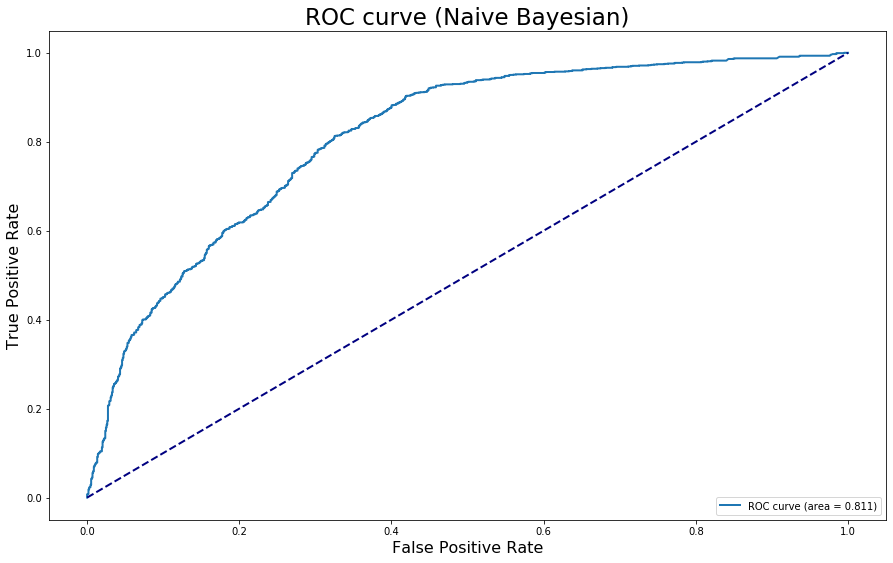

Using LSI(15 components) and Naive Bayesian: 
{}
The accuracy is  0.7510008006405124
The precision is  0.7653627527553588
The recall is  0.7372955781239491
The confusion matrix is 
[[ 669  463]
 [ 159 1207]]


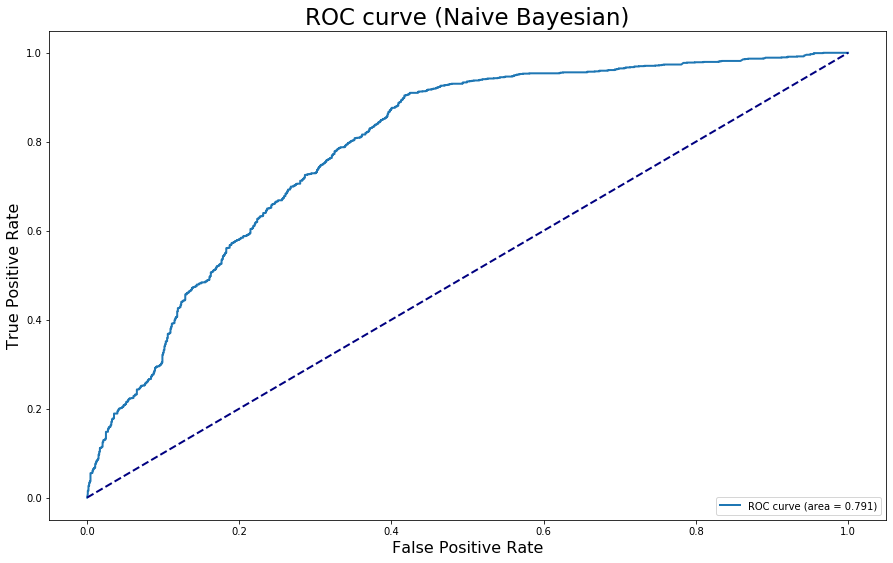

Using LSI(20 components) and Naive Bayesian: 
{}
The accuracy is  0.7618094475580465
The precision is  0.7771792211954721
The recall is  0.7483134063500768
The confusion matrix is 
[[ 684  448]
 [ 147 1219]]


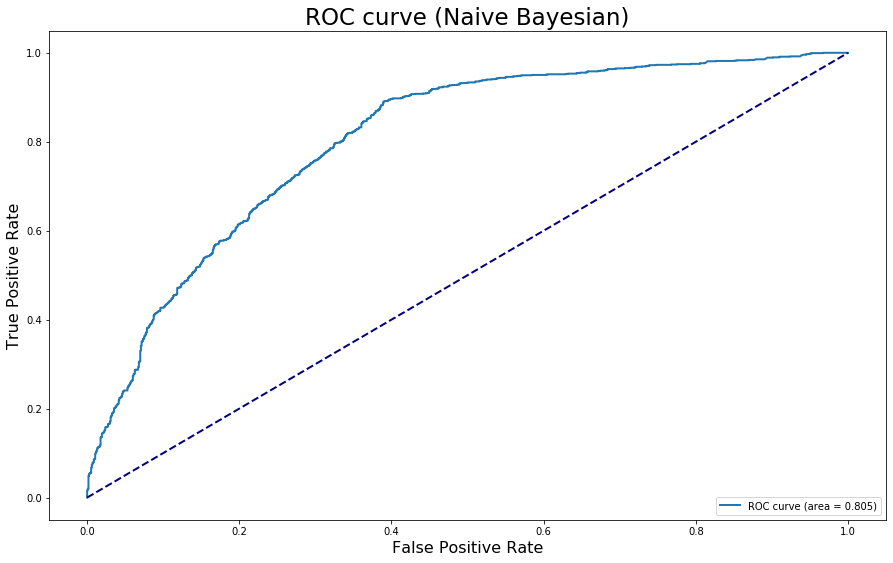

Using LSI(30 components) and Naive Bayesian: 
{}
The accuracy is  0.743795036028823
The precision is  0.75343822249422
The recall is  0.731387973449084
The confusion matrix is 
[[ 678  454]
 [ 186 1180]]


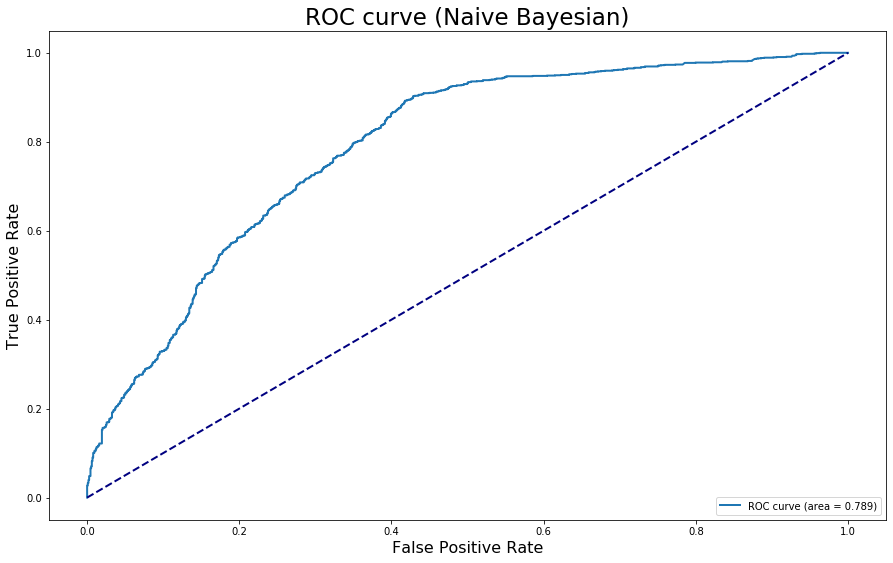

Using LSI(50 components) and Naive Bayesian: 
{}
The accuracy is  0.7057646116893515
The precision is  0.7110502888878999
The recall is  0.6932100378190171
The confusion matrix is 
[[ 633  499]
 [ 236 1130]]


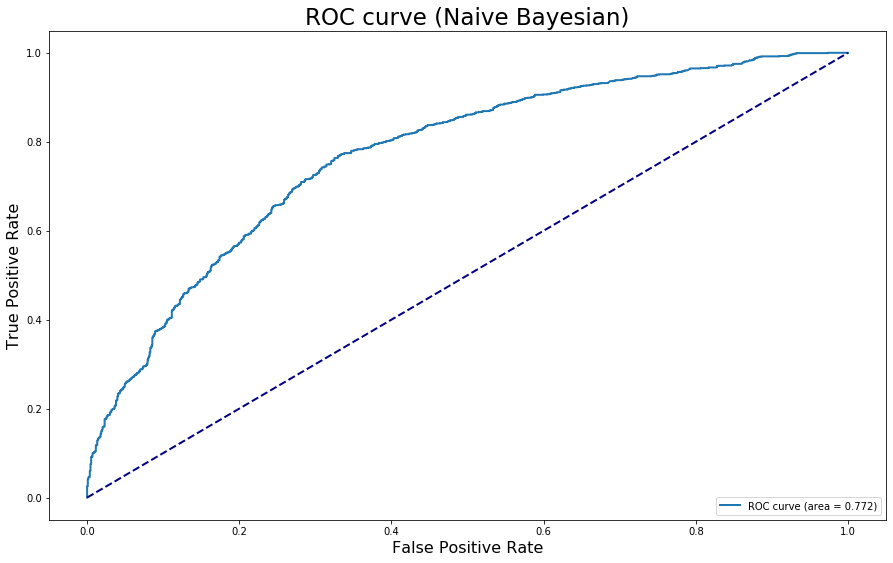

Using LSI(100 components) and Naive Bayesian: 
{}
The accuracy is  0.7113690952762209
The precision is  0.7089174473929465
The recall is  0.7065818541148229
The confusion matrix is 
[[ 742  390]
 [ 331 1035]]


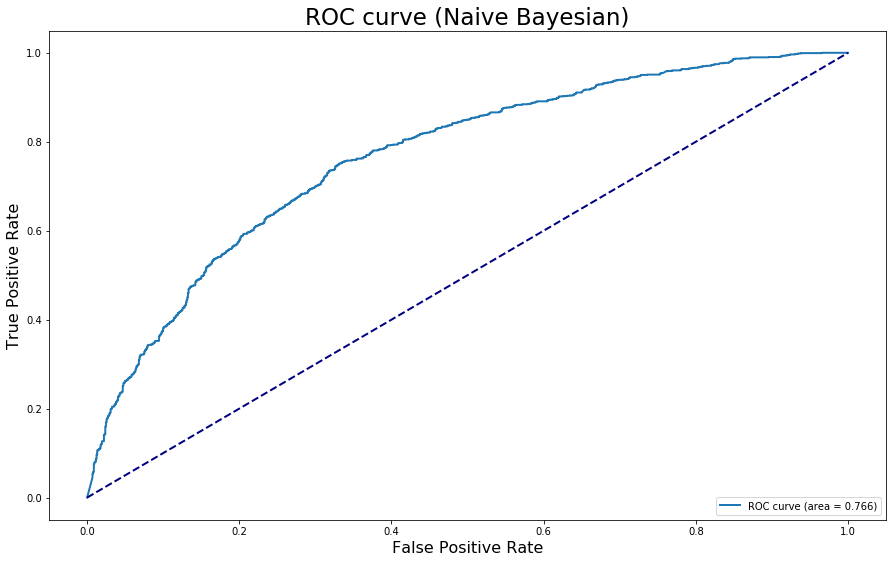

Using LSI(200 components) and Naive Bayesian: 
{}
The accuracy is  0.6569255404323459
The precision is  0.6657896263880132
The recall is  0.6644435275675284
The confusion matrix is 
[[843 289]
 [568 798]]


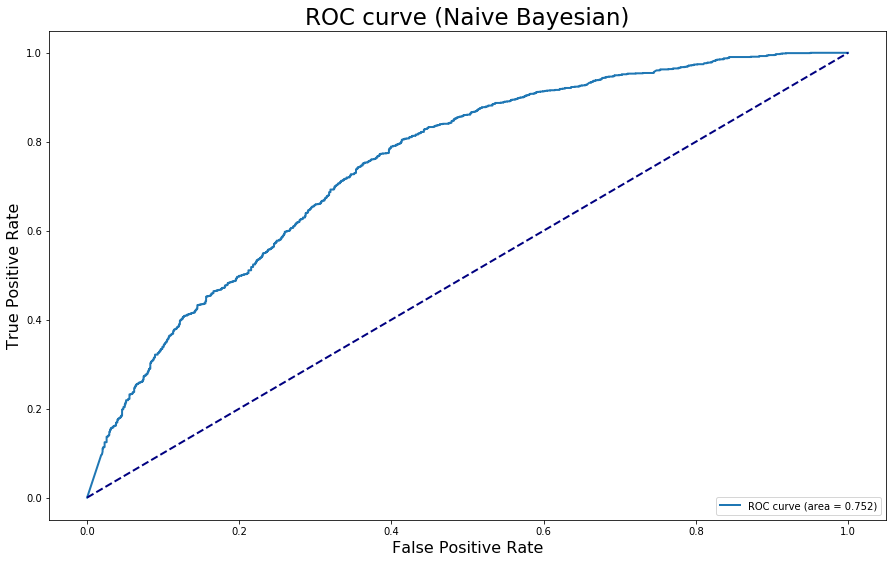

Using LSI(400 components) and Naive Bayesian: 
{}
The accuracy is  0.6933546837469976
The precision is  0.6905759996270338
The recall is  0.6903373963339869
The confusion matrix is 
[[745 387]
 [379 987]]


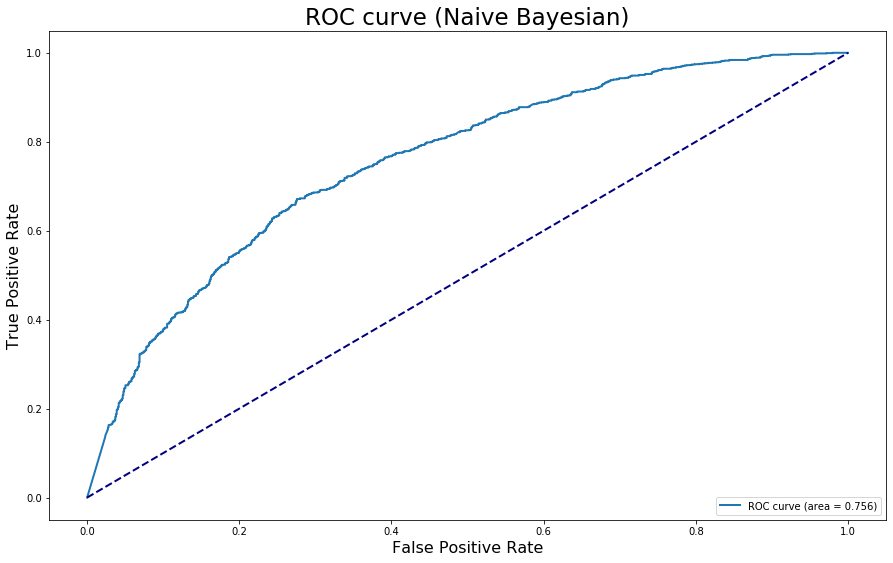

Using LSI(600 components) and Naive Bayesian: 
{}
The accuracy is  0.6789431545236189
The precision is  0.6773263130859124
The recall is  0.6785978508864964
The confusion matrix is 
[[764 368]
 [434 932]]


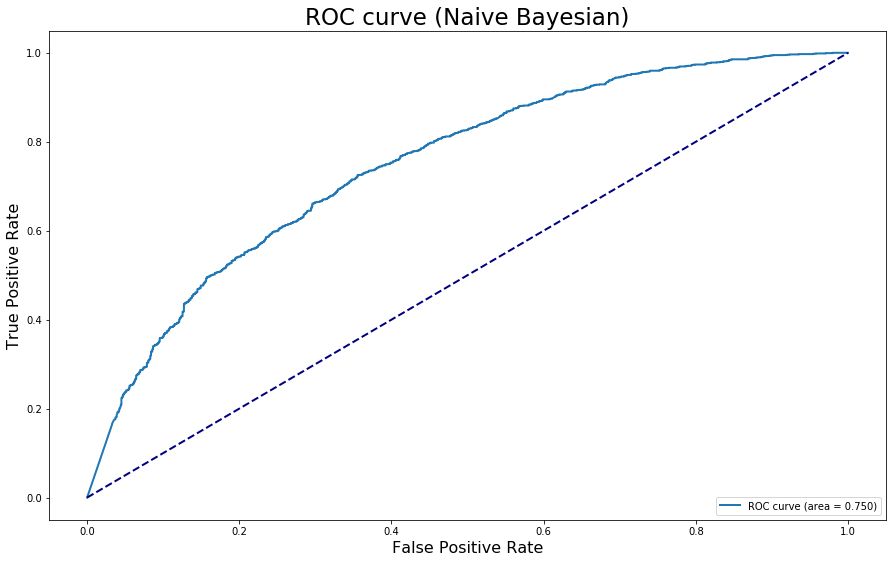

Using LSI(800 components) and Naive Bayesian: 
{}
The accuracy is  0.6737389911929543
The precision is  0.6738907745907814
The recall is  0.6754283740926799
The confusion matrix is 
[[785 347]
 [468 898]]


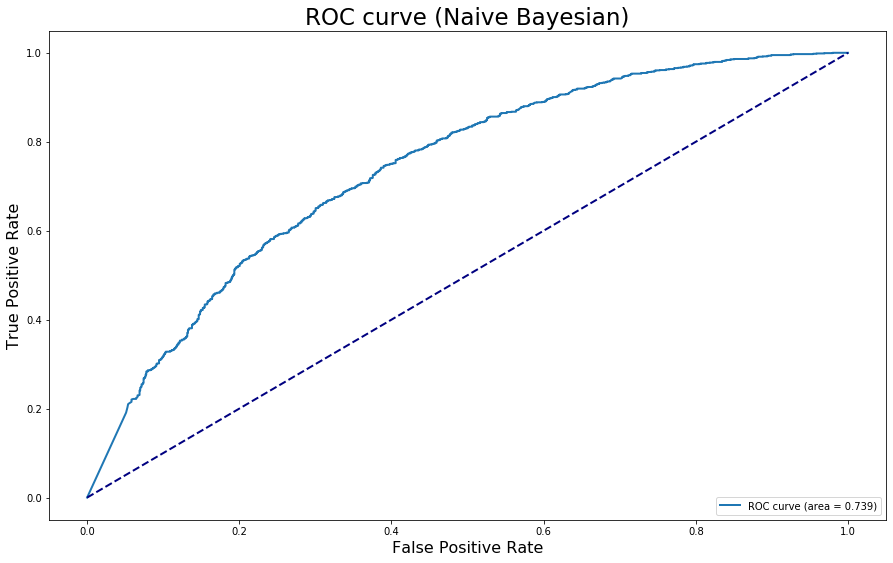

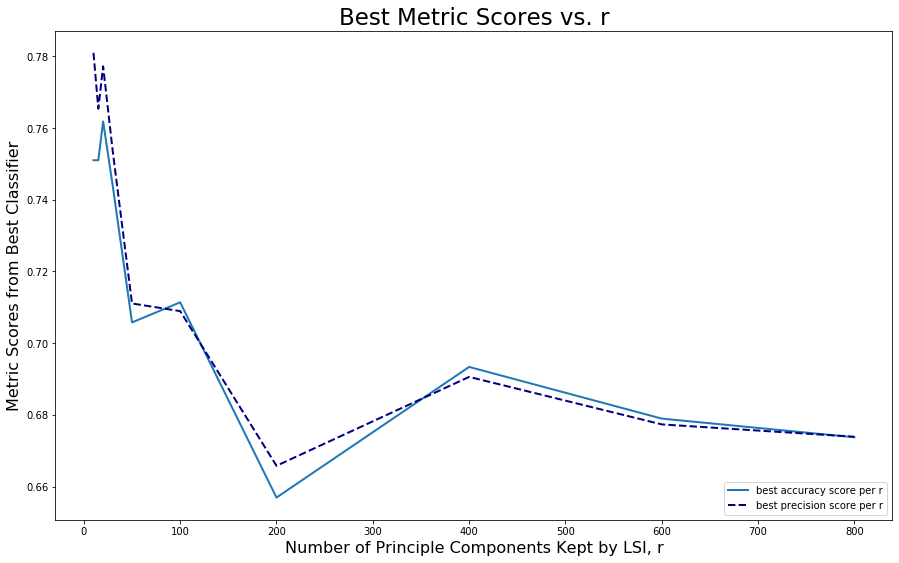

In [69]:
#searching for the optimal parameter takes too long, so we used rather simple classifiers to have reasonable runtime
#run with SVM, Logistic Regression, naive Bayesian
#since Bayesian does not have param to tweak, we use Bayesian to find a reasonable range of r first
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
classify(clf, 'Naive Bayesian',{},'proba')

Using LSI(140 components) and SVM: 
{'C': 50000}
The accuracy is  0.8074459567654123
The precision is  0.8372451578214988
The recall is  0.7924623232568848
The confusion matrix is 
[[ 716  416]
 [  65 1301]]


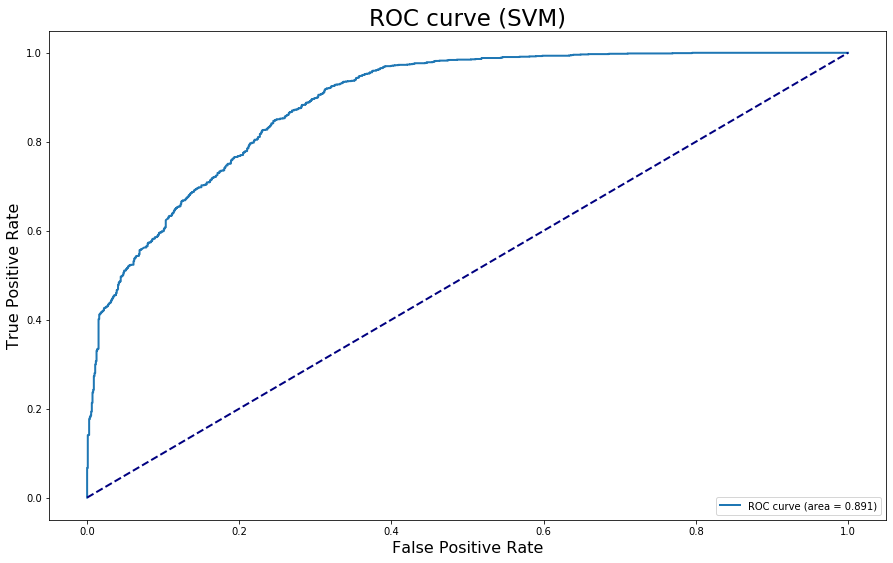

Using LSI(200 components) and SVM: 
{'C': 50000}
The accuracy is  0.811048839071257
The precision is  0.8408559164622675
The recall is  0.7962105965678337
The confusion matrix is 
[[ 722  410]
 [  62 1304]]


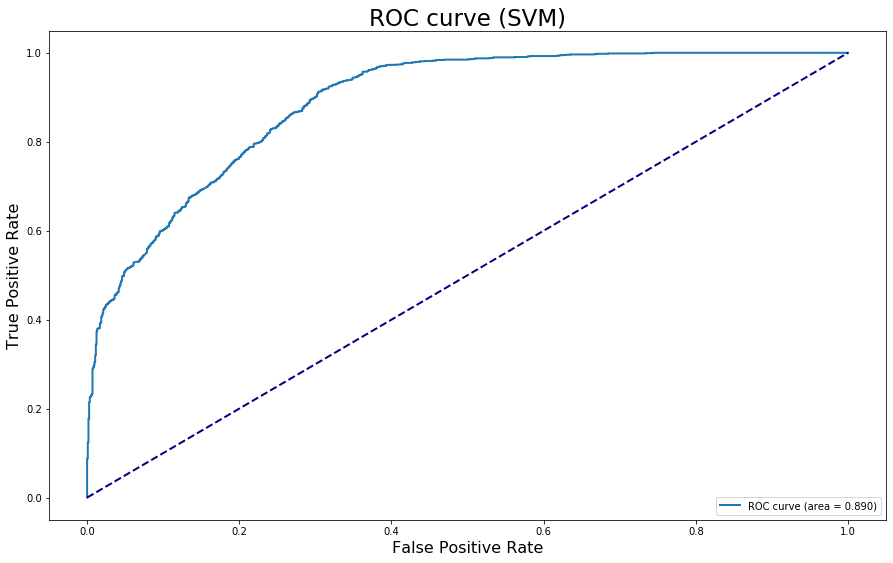

Using LSI(280 components) and SVM: 
{'C': 5000}
The accuracy is  0.8106485188150521
The precision is  0.8429539390034074
The recall is  0.7953149170413216
The confusion matrix is 
[[ 715  417]
 [  56 1310]]


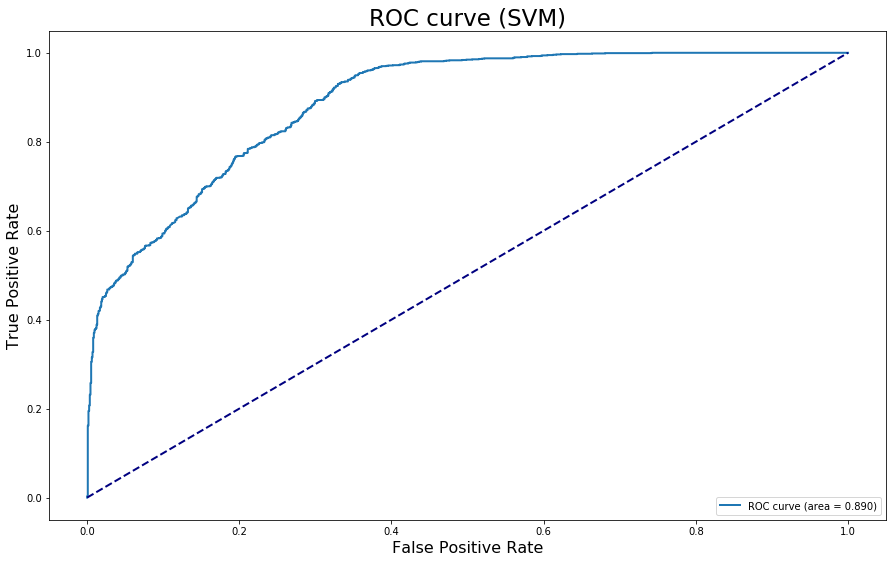

Using LSI(350 components) and SVM: 
{'C': 50000}
The accuracy is  0.8098478783026422
The precision is  0.839653496866727
The recall is  0.7949611721308507
The confusion matrix is 
[[ 720  412]
 [  63 1303]]


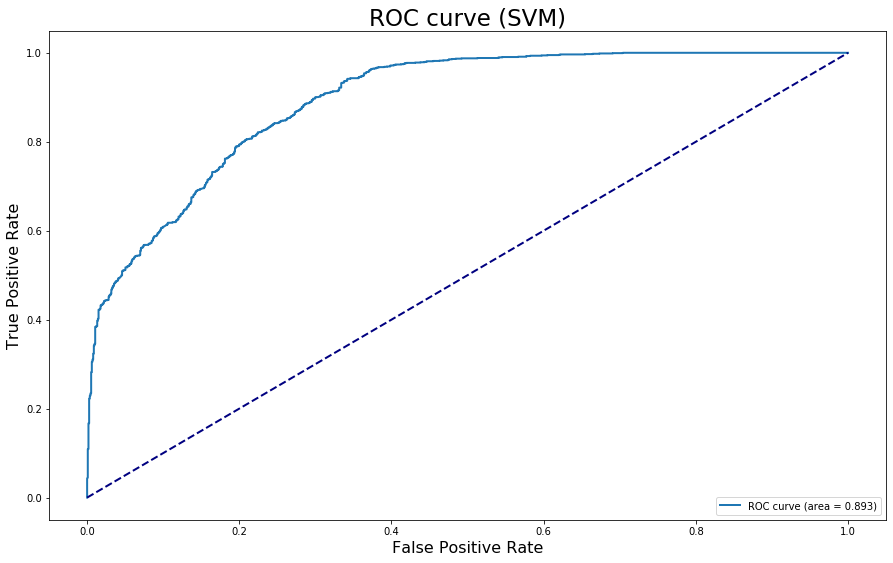

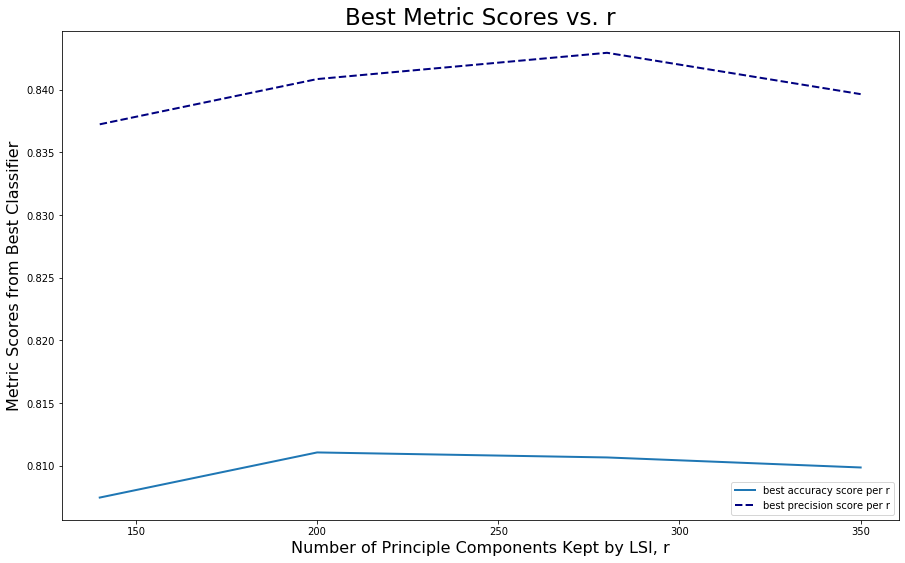

In [267]:
from sklearn import svm, linear_model
import warnings

warnings.filterwarnings("ignore")

clf = svm.SVC()
classify(clf, 'SVM', {'C':[1, 10, 100, 1000, 5000, 10000, 50000]}, 'non-proba', r=[140, 200, 280, 350]) 

Using LSI(60 components) and SVM: 
{'C': 10000}
The accuracy is  0.8054443554843875
The precision is  0.8370550745550746
The recall is  0.7900268509847947
The confusion matrix is 
[[ 708  424]
 [  62 1304]]


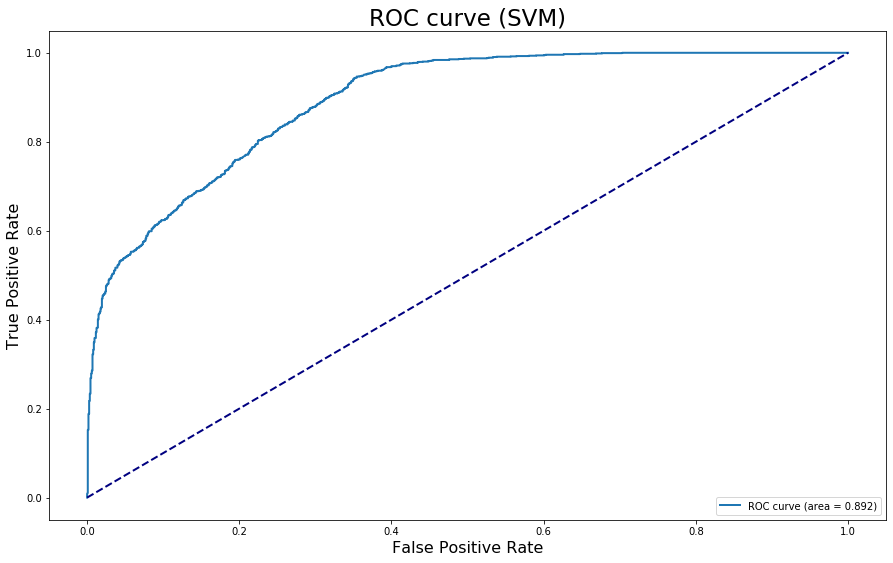

Using LSI(100 components) and SVM: 
{'C': 1000}
The accuracy is  0.8138510808646917
The precision is  0.8458925729691273
The recall is  0.7986971581414359
The confusion matrix is 
[[ 721  411]
 [  54 1312]]


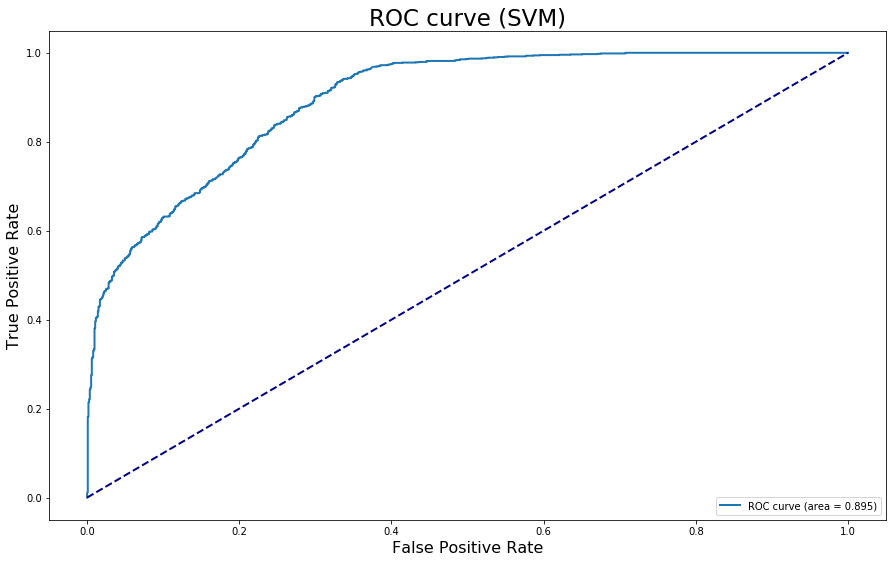

Using LSI(140 components) and SVM: 
{'C': 5000}
The accuracy is  0.8142514011208967
The precision is  0.8426631366705691
The recall is  0.799819829374667
The confusion matrix is 
[[ 731  401]
 [  63 1303]]


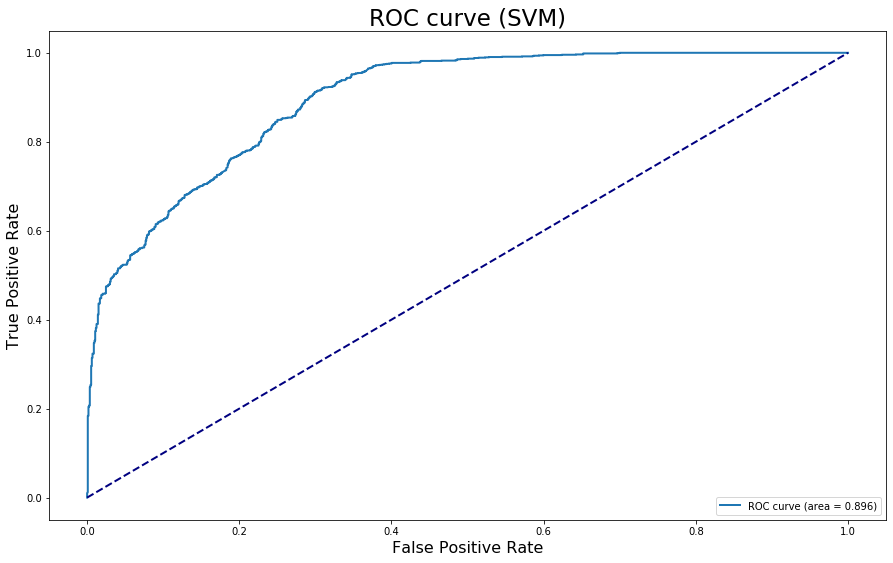

Using LSI(180 components) and SVM: 
{'C': 1000}
The accuracy is  0.8122497998398719
The precision is  0.8383577977275812
The recall is  0.7982166600272131
The confusion matrix is 
[[ 734  398]
 [  71 1295]]


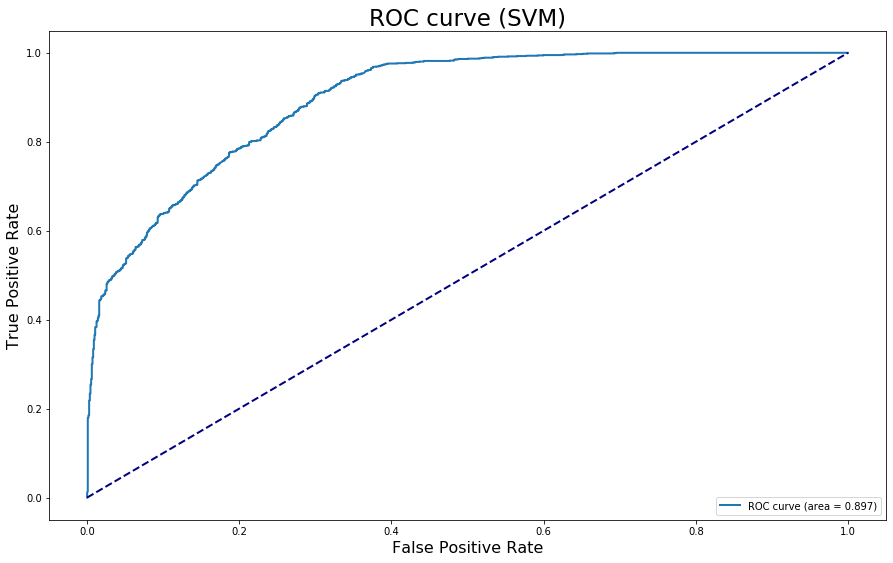

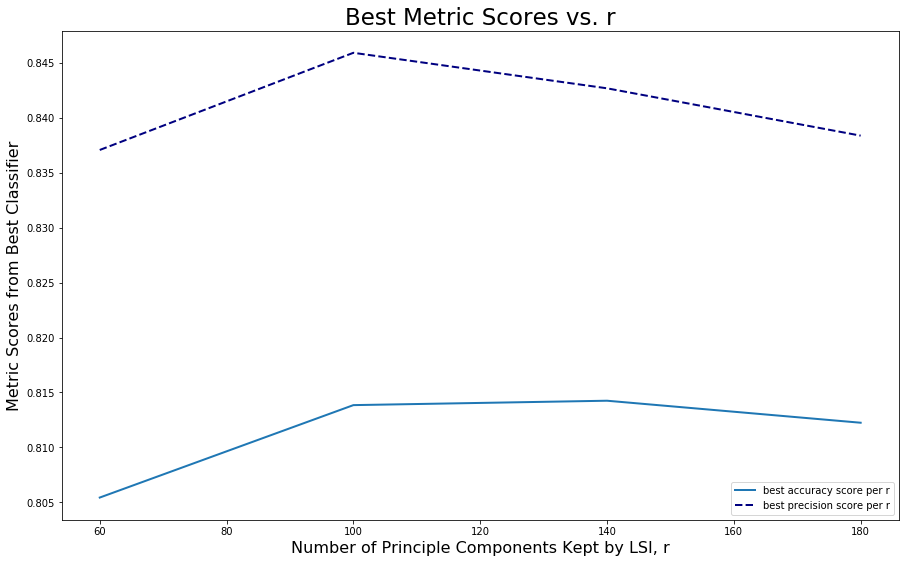

In [73]:
clf = linear_model.LogisticRegression()
classify(clf, 'SVM', {'C':[0.1, 1, 10, 100, 1000, 5000, 10000]}, 'proba', r=[60, 100, 140, 180]) #100

## Part 3 -- Define your Own Project

### 16.

The dataset in hands is rich as there is a lot of metadata to each tweet. Be creative and propose a new problem (something interesting that can be inferred from this dataset) other than the previous parts. You can look into the literature of Twitter data analysis to get some ideas. Implement your idea and show that it works. As a suggestion, you might provide some analysis based on changes of tweet sentiments for fans of the opponent teams participating in the match. You get full credit for briniging in novelty and full or partial implementation of your new ideas.

In this part we play around with sentiment analysis of the dataset and try to see if we can use the polarity of a tweet to predict or help to improve prediction of the popularity of the tweet, as indicated by number of retweet it receives.

In [268]:
#First we get sentiments of the tweets in the superbowl dataset.
#reuse processed data in pp_text, texts and locales
import sys
!{sys.executable} -m pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 

#helper function for sentiment scores
def sentiment_scores(sentence, verbose=False): 
  
    SIA = SentimentIntensityAnalyzer() 
  
    # polarity_scores method of SentimentIntensityAnalyzer 
    # oject gives a sentiment dictionary. 
    # which contains pos, neg, neu, and compound scores. 
    sentiment_dict = SIA.polarity_scores(sentence) 
    
    if(verbose):
        print("Overall sentiment dictionary is : ", sentiment_dict) 
        print("sentence was rated as ", sentiment_dict['neg']*100, "% Negative") 
        print("sentence was rated as ", sentiment_dict['neu']*100, "% Neutral") 
        print("sentence was rated as ", sentiment_dict['pos']*100, "% Positive") 

        print("Sentence Overall Rated As", end = " ") 

        # decide sentiment as positive, negative and neutral 
        if sentiment_dict['compound'] >= 0.05 : 
            print("Positive") 

        elif sentiment_dict['compound'] <= - 0.05 : 
            print("Negative") 

        else : 
            print("Neutral")
        
    return sentiment_dict['compound']

def getSentiment(score):
    if score >= 0.05: 
        return 1 #for pos
    elif score <= - 0.05: 
        return -1 #for neg 
    else: 
        return 0 #for neutral

In [276]:
#read more contextual data to play around
#we want to focus on period2 since the sentiment are most likely to change during the gameday
filepath = './tweet_data/tweets_#superbowl.txt'
fh = open(filepath, 'r')
min_from_8am = []
followers_count = []
full_count = []
retweet_count = []
gameday_locales = []
gameday_texts = []
pst_tz = pytz.timezone('America/Los_Angeles')

for line in fh:
    data = json.loads(line)
    timestamp=(data['citation_date'])
    timedata= datetime.datetime.fromtimestamp(timestamp,pst_tz)
    location = data['tweet']['user']['location']
    locale_tag = parse_locale(location)
    #we are insterested only in the potential fans of the playing teams.
    if ((timedata.day == 1 and timedata.hour >=8 and timedata.hour <20) and (locale_tag != -1)):
        gameday_locales.append(locale_tag)
        gameday_texts.append(data['title'])
        hour = timedata.hour
        minute = timedata.minute
        min_from_8am.append((hour - 8)*60 + minute)
        followers_count.append([data['author']['followers']])
        full_count.append([data['author']['followers'], data['tweet']['user']['friends_count'], data['tweet']['user']['favourites_count']])
        retweet_count.append(data['metrics']['citations']['total'])

fh.close()
print(len(min_from_8am))

14229


In [269]:
#helper: get sentiment scores and tags from the sanitized texts
def getScores(texts):
    sentiments = []
    sia_scores = []
    for text in texts:
        re.sub('http.*', '', text) #reduce bad features
        word_list = nltk.word_tokenize(text)
        lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
        #get scores and sentiment tag
        compound_score = sentiment_scores(lemmatized_output)
        sentiments.append(getSentiment(compound_score))
        sia_scores.append(compound_score)
    
    return sentiments, sia_scores

#helper for obtaining plotting data
def updateCounts(pos, neg, comp, sentiments, sia_scores, index):
    comp += sia_scores[index]
    if(sentiments[index] > 0): pos+=1
    elif(sentiments[index] < 0): neg+=1
    return pos, neg, comp

In [270]:
#now we check sentiments changes in the fan base on the gameday


#get sentiment tag and score
sentiments, sia_scores = getScores(gameday_texts)


In [121]:
#print(min_from_8am) #check if organized by time
times = np.unique(min_from_8am)
#print(times)
print(len(times))
#get number of pos, neg per min per team, and measure total compound score per min per team, then plot teams together
pos_WA = []
neg_WA = []
comp_WA = []

pos_MA = []
neg_MA = []
comp_MA = []

num_tweet = len(min_from_8am)
print(num_tweet)

checked = []
i = 0
while i < num_tweet:
    if(i%1000 == 0):print(str(i/num_tweet * 100) + '%done')
    curtime = min_from_8am[i]
    if(curtime in checked): 
        i += 1
        continue
    else: checked.append(curtime)
    
    posW, negW, compW = 0,0,0
    posM, negM, compM = 0,0,0
        
    if(gameday_locales[i] == 0): #in WA
        posW, negW, compW = updateCounts(posW, negW, compW, sentiments, sia_scores, i)
    else:
        posM, negM, compM = updateCounts(posM, negM, compM, sentiments, sia_scores, i)
    
    j = i + 1
    while j < num_tweet:
        if(curtime == min_from_8am[j]): 
            if(gameday_locales[j]==0):
                posW, negW, compW = updateCounts(posW, negW, compW, sentiments, sia_scores, j)
            else:
                posM, negM, compM = updateCounts(posM, negM, compM, sentiments, sia_scores, j)
        j+=1
    #now we find all data at the same min
    pos_WA.append(posW)
    neg_WA.append(negW)
    comp_WA.append(compW)
    pos_MA.append(posM)
    neg_MA.append(negM)
    comp_MA.append(compM)
    i+=1
        
print(len(checked))

697
14229
0.0%done
7.027900766041184%done
14.055801532082368%done
21.083702298123548%done
28.111603064164736%done
35.13950383020592%done
42.167404596247096%done
49.19530536228828%done
56.22320612832947%done
63.25110689437066%done
70.27900766041184%done
77.30690842645302%done
84.33480919249419%done
91.36270995853538%done
98.39061072457656%done
697


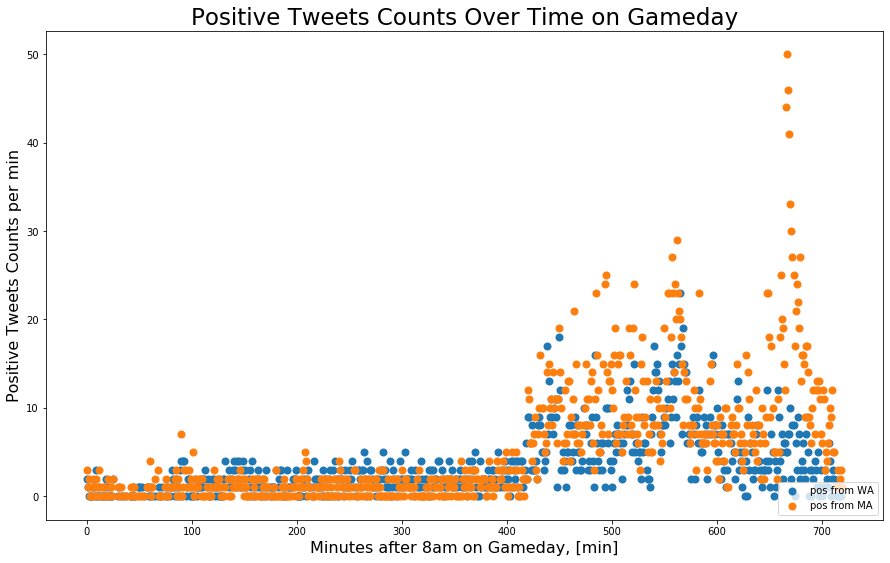

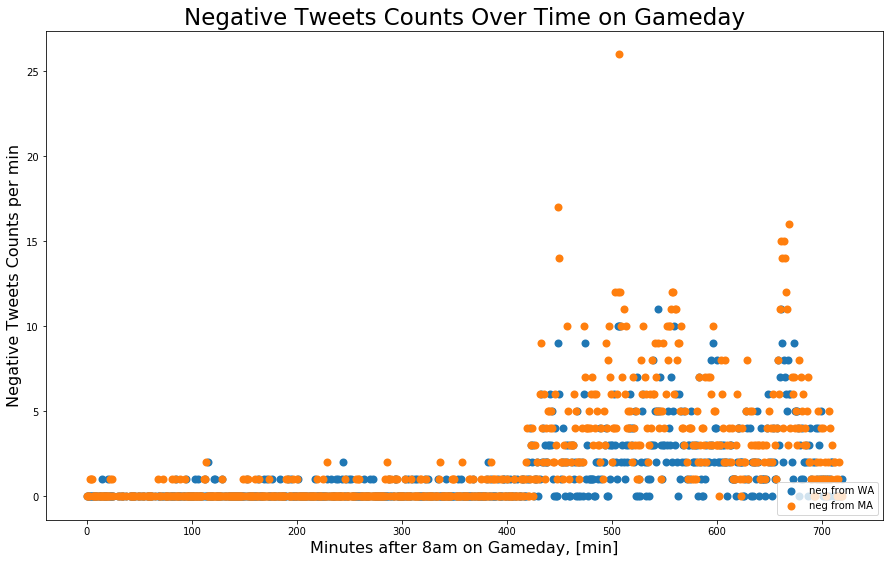

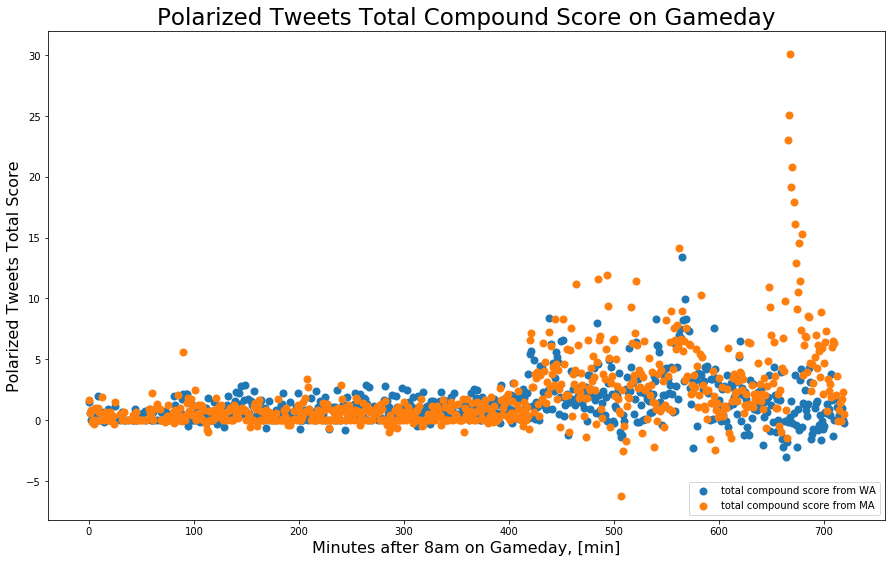

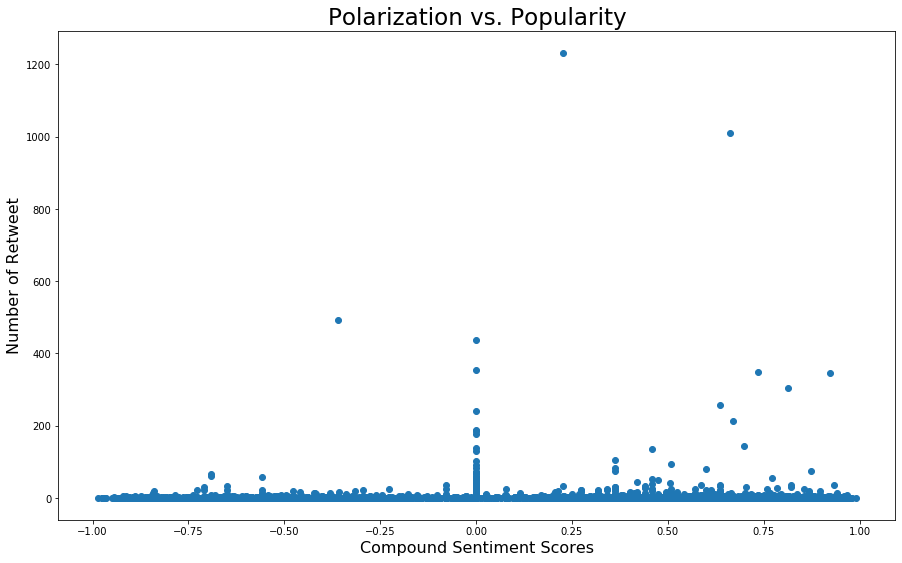

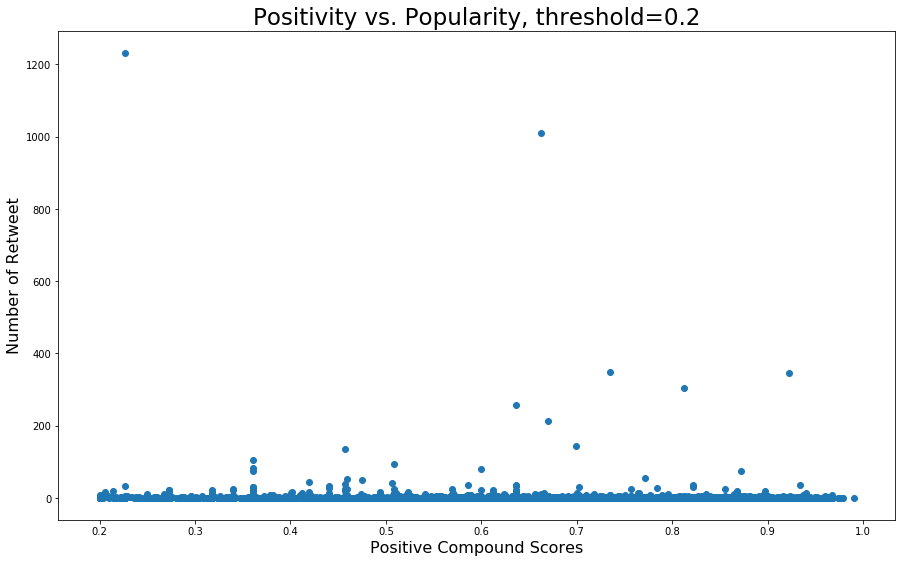

In [273]:
# we plot negW, posW, negM, posM vs. time and compW, compM vs. time
#trim min_from_8am by combine 
plt.figure(figsize=(15,9))
plt.scatter(checked, pos_WA, lw=2, label='pos from WA')
plt.scatter(checked, pos_MA, lw=2, label='pos from MA')
plt.xlabel('Minutes after 8am on Gameday, [min]', fontsize=16)
plt.ylabel('Positive Tweets Counts per min', fontsize=16)
plt.title('Positive Tweets Counts Over Time on Gameday', fontsize=23)
plt.legend(loc="lower right")
plt.show()

plt.figure(figsize=(15,9))
plt.scatter(checked, neg_WA, lw=2, label='neg from WA')
plt.scatter(checked, neg_MA, lw=2, label='neg from MA')
plt.xlabel('Minutes after 8am on Gameday, [min]', fontsize=16)
plt.ylabel('Negative Tweets Counts per min', fontsize=16)
plt.title('Negative Tweets Counts Over Time on Gameday', fontsize=23)
plt.legend(loc="lower right")
plt.show()
    

plt.figure(figsize=(15,9))
plt.scatter(checked, comp_WA, lw=2, label='total compound score from WA')
plt.scatter(checked, comp_MA, lw=2, label='total compound score from MA')

plt.xlabel('Minutes after 8am on Gameday, [min]', fontsize=16)
plt.ylabel('Polarized Tweets Total Score', fontsize=16)
plt.title('Polarized Tweets Total Compound Score on Gameday', fontsize=23)
plt.legend(loc="lower right")
plt.show()

#now we check whether polarity is related to retweet
plt.figure(figsize=(15,9))
plt.scatter(sia_scores, retweet_count)
plt.xlabel('Compound Sentiment Scores', fontsize=16)
plt.ylabel('Number of Retweet', fontsize=16)
plt.title('Polarization vs. Popularity', fontsize=23)
plt.show()

#visualize correlation between pos tweet and retweet
pos_scores = []
pos_retweet = []
pos_threshold = 0.2
for i in range(len(sia_scores)):
    if(sia_scores[i] >= pos_threshold):
        pos_scores.append(sia_scores[i])
        pos_retweet.append(retweet_count[i])
plt.figure(figsize=(15,9))
plt.scatter(pos_scores, pos_retweet)
plt.xlabel('Positive Compound Scores', fontsize=16)
plt.ylabel('Number of Retweet', fontsize=16)
plt.title('Positivity vs. Popularity, threshold='+str(pos_threshold), fontsize=23)
plt.show()
    

In [277]:
#now we want to train on polarity to predict retweet
#intuitively follower should be a good indicator of popularity (number of retweet), 
#so we train on follower counts first for comparison

from sklearn.model_selection import KFold
#arbitrarily choose linear regression for simplicity (we only care about comparison, absolute performance does not matter)
#define helper classify function
def predict_retweet(X, y):
    accuracy = []
    precision = []
    agent = linear_model.LogisticRegression()
    kf = KFold(n_splits=10, random_state=None, shuffle=False)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        agent.fit(X_train, y_train)
        predicted = agent.predict(X_test)
    
        a, p = get_metrics(y_test, predicted, False)
        accuracy.append(a)
        precision.append(p)

    return sum(accuracy)/len(accuracy), sum(precision)/len(precision)

def binary_popularity(retweet_count):
    if(retweet_count > 1): return 1 #we set the threshold to 1 since majority of tweets has no retweets
    else: return 0


In [278]:
#first we get baseline, an intuitive collection of feature that should capture popularity of the tweet
popularity = [binary_popularity(i) for i in retweet_count]
a, p =0,0
a, p = predict_retweet(np.array(followers_count), np.array(popularity))
print('For Followers Counts: \nAverage accuracy and precision are respectively: '+str(a) + ', ' + str(p))

For Followers Counts: 
Average accuracy and precision are respectively: 0.8169233992881664, 0.8211511291730156


In [281]:
#now we add positivity score to the mix
new_feature = []
pos_retweet = []
pos_threshold = 0.5
for i in range(len(sia_scores)):
    if(sia_scores[i] >= pos_threshold):
        new_feature.append([sia_scores[i], followers_count[i][0]])
        pos_retweet.append(binary_popularity(retweet_count[i]))
a,p = 0,0
a, p = predict_retweet(np.array(new_feature), np.array(pos_retweet))
print('For Followers and Positivity: \nAverage accuracy and precision are respectively: '+str(a) + ', ' + str(p))

For Followers and Positivity: 
Average accuracy and precision are respectively: 0.8159775961510594, 0.8136637851035176


In [282]:
#use full set of intuitive feature (follower, friends, favourites)
a, p = 0,0
a, p = predict_retweet(np.array(full_count), np.array(popularity))
print('For Followers, Friends and Favourites Counts: \nAverage accuracy and precision are respectively: '+str(a) + ', ' + str(p))

For Followers, Friends and Favourites Counts: 
Average accuracy and precision are respectively: 0.8151664487280985, 0.8008361824448054


In [283]:
#add positivity to the feature
new_feature = []
pos_threshold = 0.5
copy = full_count
for i in range(len(sia_scores)):
    if(sia_scores[i] >= pos_threshold):
        new_feature.append([copy[i][0], copy[i][1], copy[i][2], sia_scores[i]])
#print(new_feature)
        
a, p = predict_retweet(np.array(new_feature), np.array(pos_retweet))
print('For Full Intuitive and Positivity: \nAverage accuracy and precision are respectively: '+str(a) + ', ' + str(p))

For Full Intuitive and Positivity: 
Average accuracy and precision are respectively: 0.8167862214879866, 0.8030309405564058
